# Capstone Project - Business' Advisor in Toronto
### Applied Data Science Capstone
#### IBM/Coursera

## Description of the Problem

I would like to analyze where to open a restaurant in Toronto. Continuing with the studies we have done so far on the previous courses, in this capstone I will expand them ir order to determine the most appropiate neighborhood for a restaurant.

## Description of the Data

The dataset was provided by the previous course and the foursquare API will be used to get the venues' locations.
- This dataset has three columns: PostalCode, Borough, and Neighborhood
- Boroughs with a **Not assigned** will be ignored.
- More than one neighborhood can exist in one postal code area. Those rows will be combined into one row with the neighborhoods separated with a comma.
- If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.


<img src="1.png">

## How will the data be used to solve the problem?

To get the latitude/longitude for each postal code I will use the following data set <a href="https://cocl.us/Geospatial_data">Link</a>.  
After mergin both dataset I will get something like this:

<img src="2.png">

Then, everything will be ready to use FourSquare API to retrieve venues for earch neighborhood.  
To visualize the data I will use maps and plots.  

## Methodology

### Modules

In [191]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

#import pixiedust # Debugging
import numpy as np
import pandas as pd
import json 
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
import folium # map rendering library
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

%matplotlib inline

In [2]:
# Using read_html from pandas module
# Picking the first element as it is the table we need
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
df.head()

Postcode           Borough     Neighbourhood
0      M1A      Not assigned      Not assigned
1      M2A      Not assigned      Not assigned
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront

#### Renaming columns

In [3]:
# Renaming columns
df.columns = ['PostalCode', 'Borough', 'Neighborhood']
df.head()

PostalCode           Borough      Neighborhood
0        M1A      Not assigned      Not assigned
1        M2A      Not assigned      Not assigned
2        M3A        North York         Parkwoods
3        M4A        North York  Victoria Village
4        M5A  Downtown Toronto      Harbourfront

Only process the cells that have an assigned borough. Ignore cells with a borough that is **Not assigned**.

In [4]:
# Dropping cells with a borough that is Not assigned.
df.replace("Not assigned", np.nan, inplace=True)
df.dropna(axis=0, subset=['Borough'], inplace=True)

More than one neighborhood can exist in one postal code area. Those rows will be combined into one row with the neighborhoods separated with a comma.

In [5]:
# Defining a lamnda function to process each row.
def f(x):
    return pd.Series(dict(A = x.loc[:,'PostalCode'].values[0], 
                        B = x.loc[:,'Borough'].values[0], 
                        C = x.loc[:,'Borough'].values[0] if (x['Neighborhood'].values[0] is np.nan) else ('%s' % ', '.join(x['Neighborhood']))))
    
df_grouped = df.groupby('PostalCode').apply(f)

In [6]:
# Reindexing
df_grouped.index = range(0, len(df_grouped))
df_grouped.columns = ['PostalCode', 'Borough', 'Neighborhood']
df_grouped.head()

PostalCode      Borough                            Neighborhood
0        M1B  Scarborough                          Rouge, Malvern
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union
2        M1E  Scarborough       Guildwood, Morningside, West Hill
3        M1G  Scarborough                                  Woburn
4        M1H  Scarborough                               Cedarbrae

### Adding coordinates

In [7]:
coords = pd.read_csv("Geospatial_Coordinates.csv")
latitudes = [] 
longitudes = []

for index, row in df_grouped.iterrows():
    latitudes.append(coords[coords['Postal Code'] == row['PostalCode']].values[0][1])
    longitudes.append(coords[coords['Postal Code'] == row['PostalCode']].values[0][2])
    
df_grouped = df_grouped.assign(latitude = latitudes, longitude = longitudes)
df_grouped.head()

PostalCode      Borough                            Neighborhood   latitude  \
0        M1B  Scarborough                          Rouge, Malvern  43.806686   
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [8]:
# Working only with Toronto's Boroughs
df_toronto = df_grouped[df_grouped['Borough'].str.contains(r'Toronto')]
df_toronto.head()

PostalCode          Borough                    Neighborhood   latitude  \
37        M4E     East Toronto                     The Beaches  43.676357   
41        M4K     East Toronto    The Danforth West, Riverdale  43.679557   
42        M4L     East Toronto  The Beaches West, India Bazaar  43.668999   
43        M4M     East Toronto                 Studio District  43.659526   
44        M4N  Central Toronto                   Lawrence Park  43.728020   

    longitude  
37 -79.293031  
41 -79.352188  
42 -79.315572  
43 -79.340923  
44 -79.388790

In [9]:
df_toronto.columns = map(lambda s: s.capitalize(), df_toronto.columns)

### Adding Venues

In [213]:
CLIENT_ID = '***' # your Foursquare ID
CLIENT_SECRET = '***' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

In [11]:
# Defining a function to get the venues nearby
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Getting toronto venues for each neighborhood

In [12]:

toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

#### How many groups were returned?

In [13]:

toronto_venues.head()

Neighborhood  Neighborhood Latitude  \
0                   The Beaches              43.676357   
1                   The Beaches              43.676357   
2                   The Beaches              43.676357   
3                   The Beaches              43.676357   
4  The Danforth West, Riverdale              43.679557   

   Neighborhood Longitude                               Venue  Venue Latitude  \
0              -79.293031                   Glen Manor Ravine       43.676821   
1              -79.293031  The Big Carrot Natural Food Market       43.678879   
2              -79.293031                 Grover Pub and Grub       43.679181   
3              -79.293031                       Upper Beaches       43.680563   
4              -79.352188                            Pantheon       43.677621   

   Venue Longitude     Venue Category  
0       -79.293942              Trail  
1       -79.297734  Health Food Store  
2       -79.297215                Pub  
3       -79.292869       Neighborhood  
4       -79.351434   Greek Restaurant

#### Checking whether the dataframe has null values or not

In [14]:
toronto_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 7 columns):
Neighborhood              1711 non-null object
Neighborhood Latitude     1711 non-null float64
Neighborhood Longitude    1711 non-null float64
Venue                     1711 non-null object
Venue Latitude            1711 non-null float64
Venue Longitude           1711 non-null float64
Venue Category            1711 non-null object
dtypes: float64(4), object(3)
memory usage: 93.6+ KB


#### Number of Unique Venues

In [15]:
len(toronto_venues['Venue Category'].unique())

235

#### Unique Venues in Toronto

In [27]:
toronto_venues['Venue Category'].unique()

array(['Trail', 'Health Food Store', 'Pub', 'Neighborhood',
       'Greek Restaurant', 'Ice Cream Shop', 'Cosmetics Shop',
       'Italian Restaurant', 'Brewery', 'Yoga Studio', 'Restaurant',
       'Fruit & Vegetable Store', 'Dessert Shop', 'Pizza Place',
       'Juice Bar', 'Bookstore', 'Indian Restaurant',
       'Furniture / Home Store', 'Grocery Store', 'Spa', 'Diner',
       'Bubble Tea Shop', 'Coffee Shop', 'Caribbean Restaurant', 'Bakery',
       'Sports Bar', 'Café', 'American Restaurant', 'Sushi Restaurant',
       'Liquor Store', 'Gym', 'Burger Joint', 'Fish & Chips Shop', 'Park',
       'Pet Store', 'Burrito Place', 'Steakhouse', 'Movie Theater',
       'Fast Food Restaurant', 'Sandwich Place', 'Food & Drink Shop',
       'Fish Market', 'Gay Bar', 'Cheese Shop', 'Chinese Restaurant',
       'Middle Eastern Restaurant', 'Thai Restaurant',
       'Comfort Food Restaurant', 'Stationery Store',
       'Seafood Restaurant', 'Coworking Space', 'Gastropub',
       'Latin American 

### Plot

#### Plotting quantity of venues per neighborhood
As we can see in the previous list, there are 235 categories on Toronto. 
How many per neighborhood?

In [189]:
def plot_venues(df, column):
    values = [neighborhood for neighborhood in toronto_venues[column].unique()]
    for value in values:
        plt.figure(figsize=(30,5))
        sns.set(font_scale=1.5)
        plt.title(value)
        sns.countplot(y='Venue Category', data = toronto_venues, order = toronto_venues[toronto_venues[column] == value]['Venue Category'].value_counts().iloc[:10].index)
        #plt.savefig(value+".png")

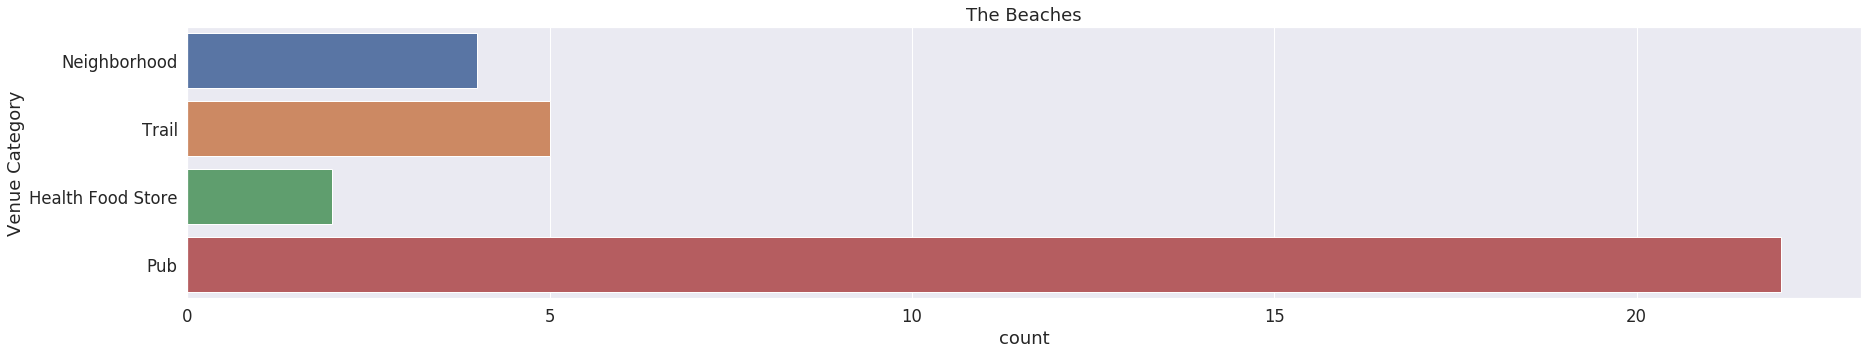

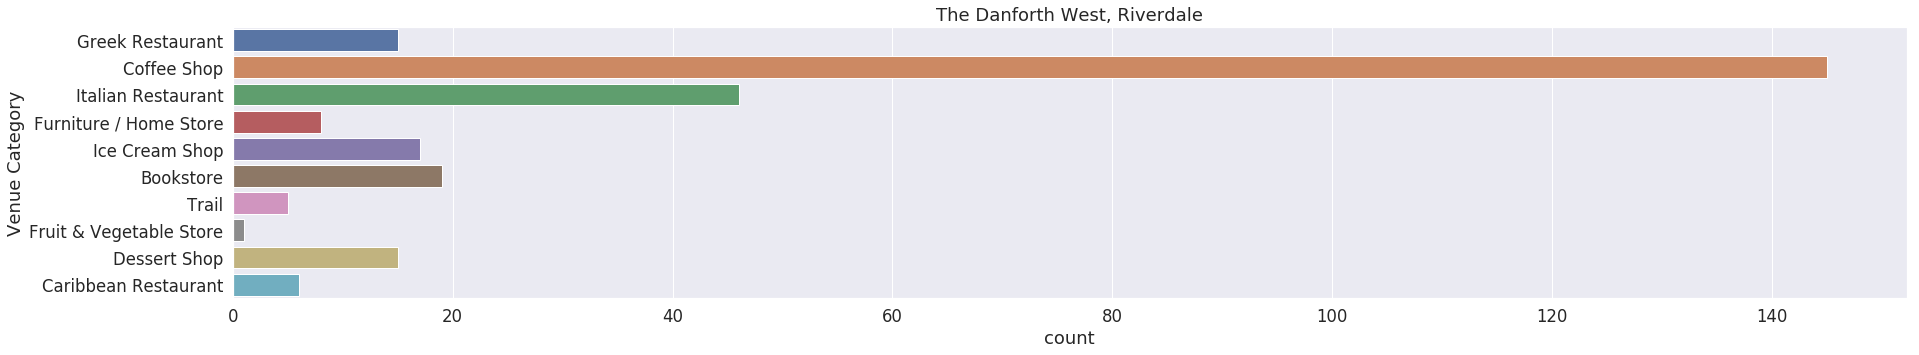

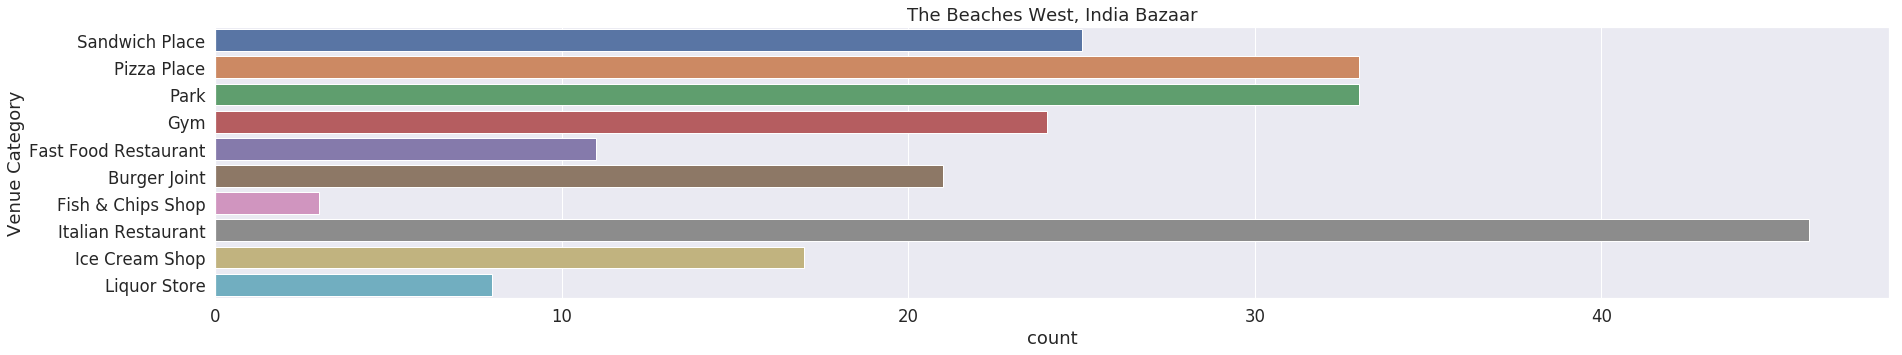

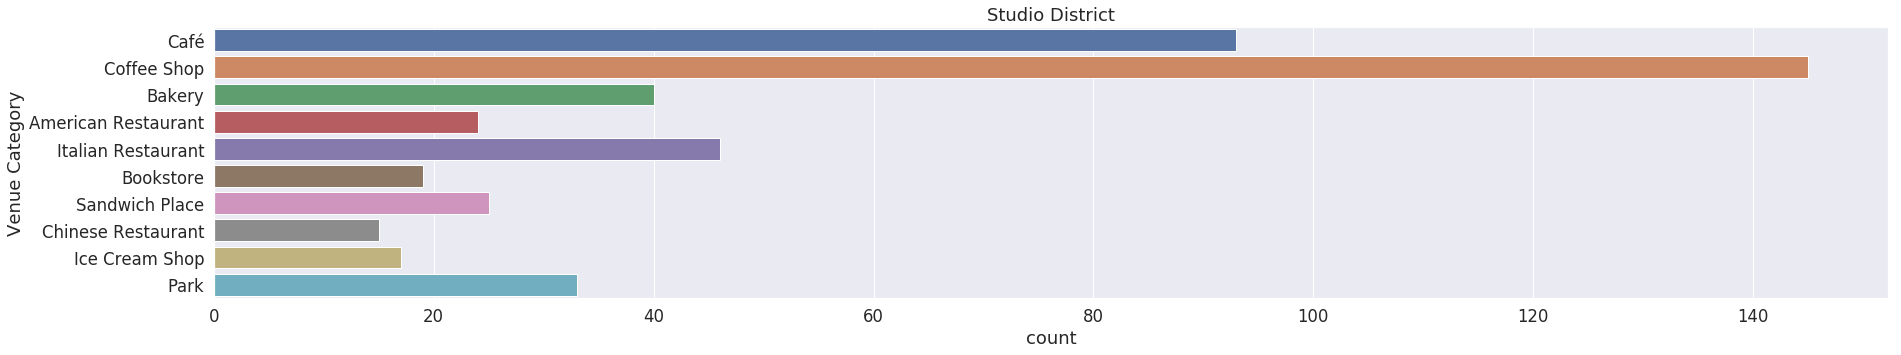

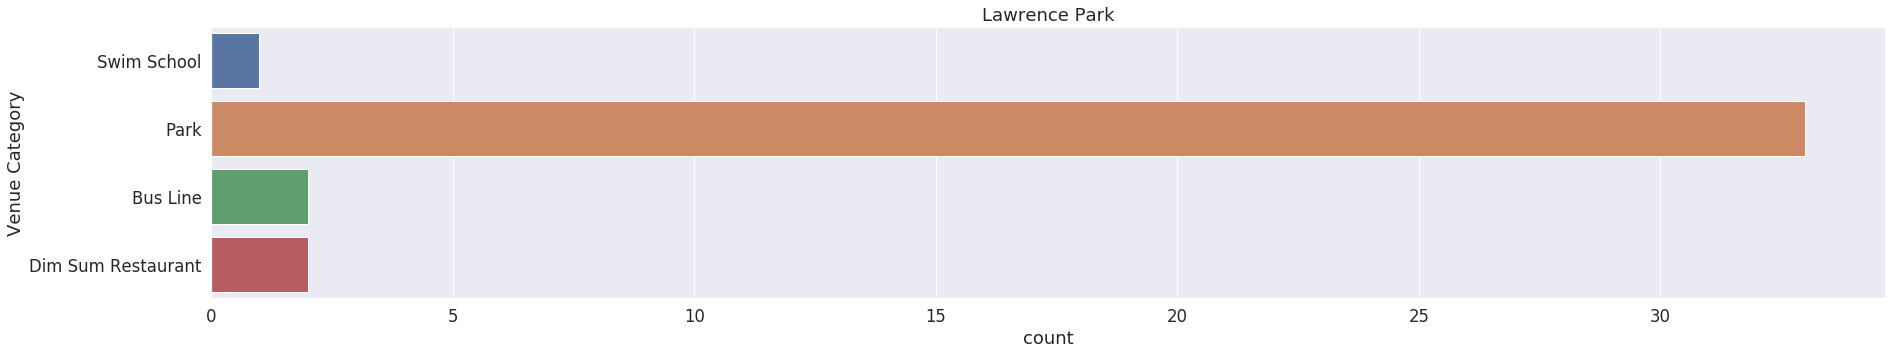

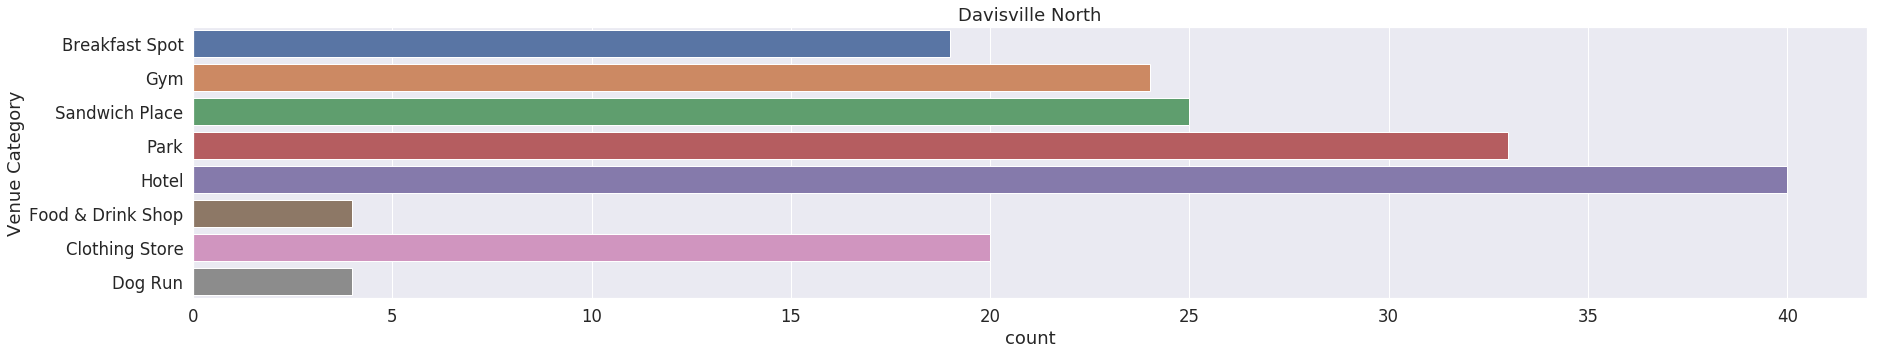

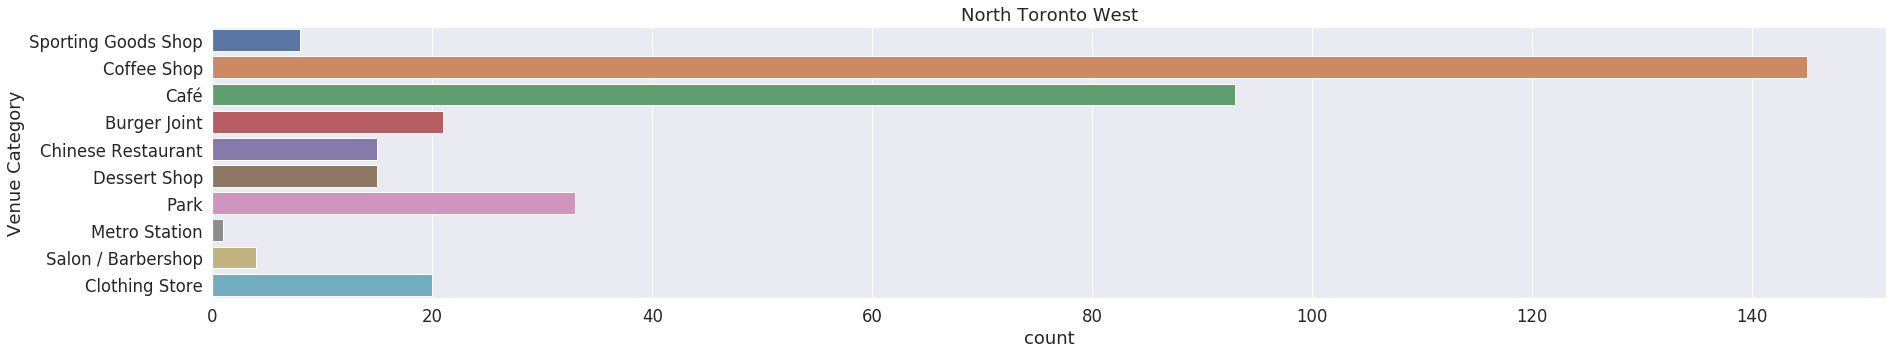

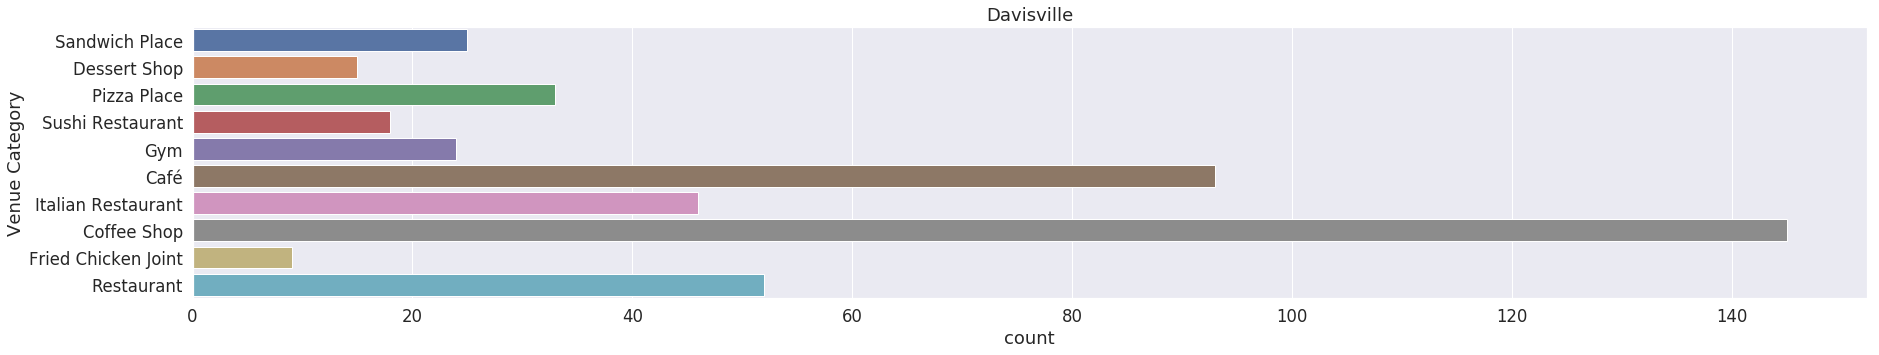

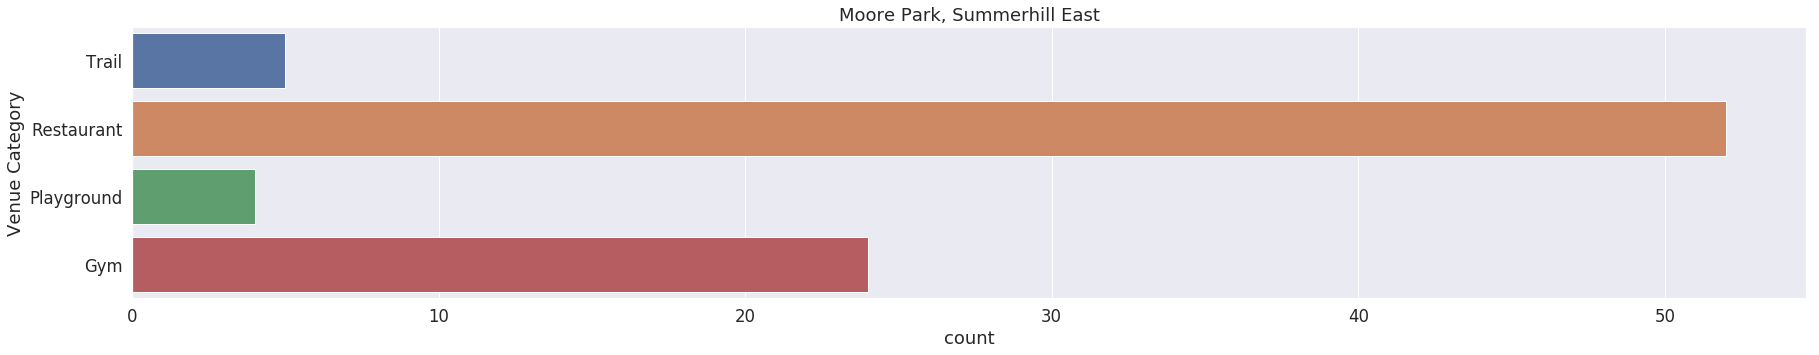

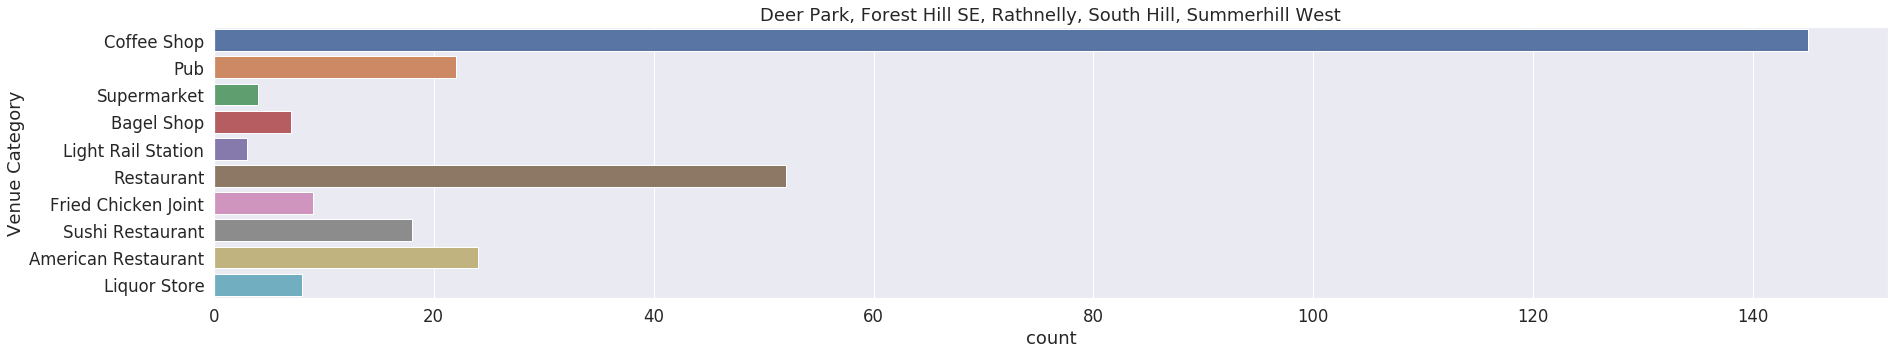

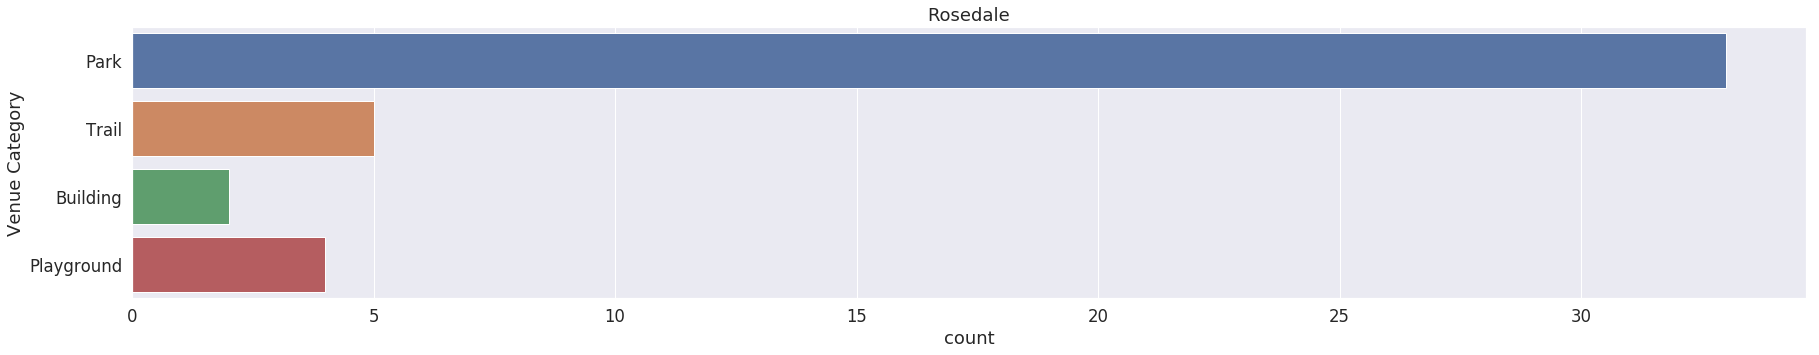

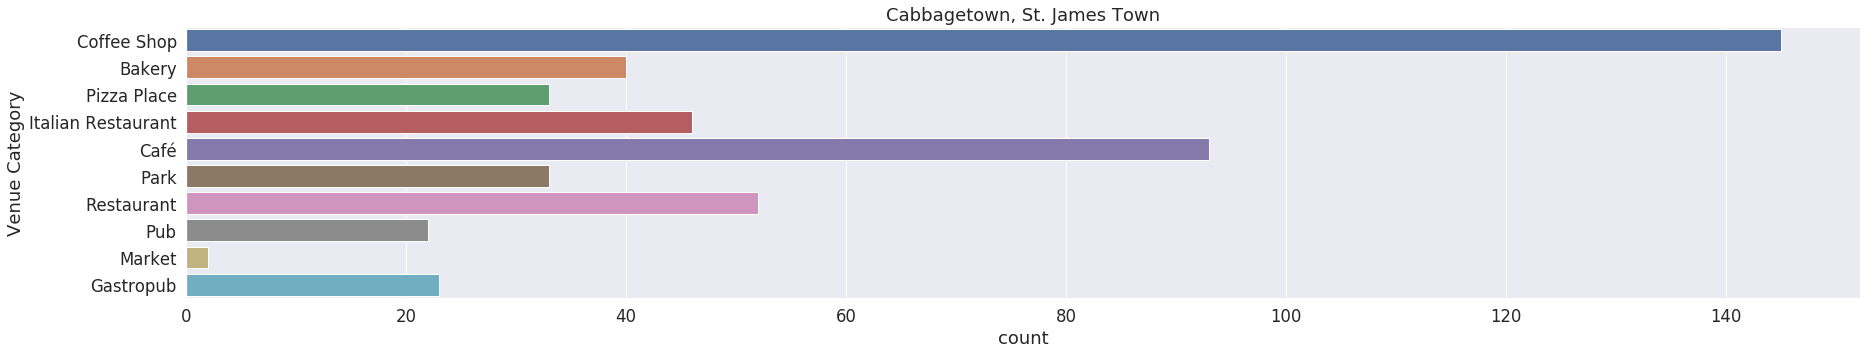

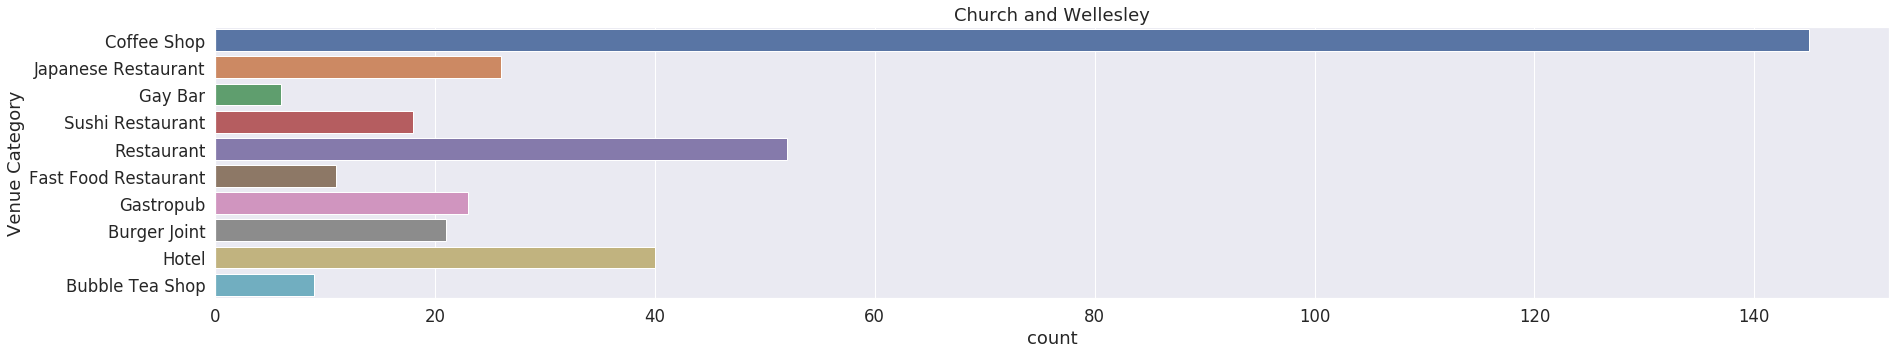

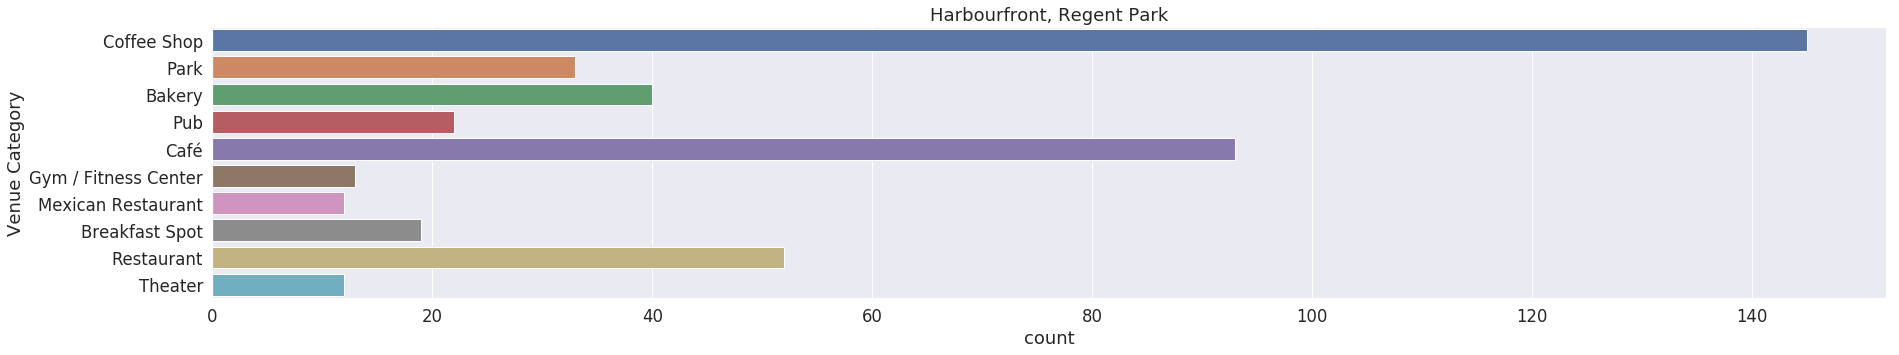

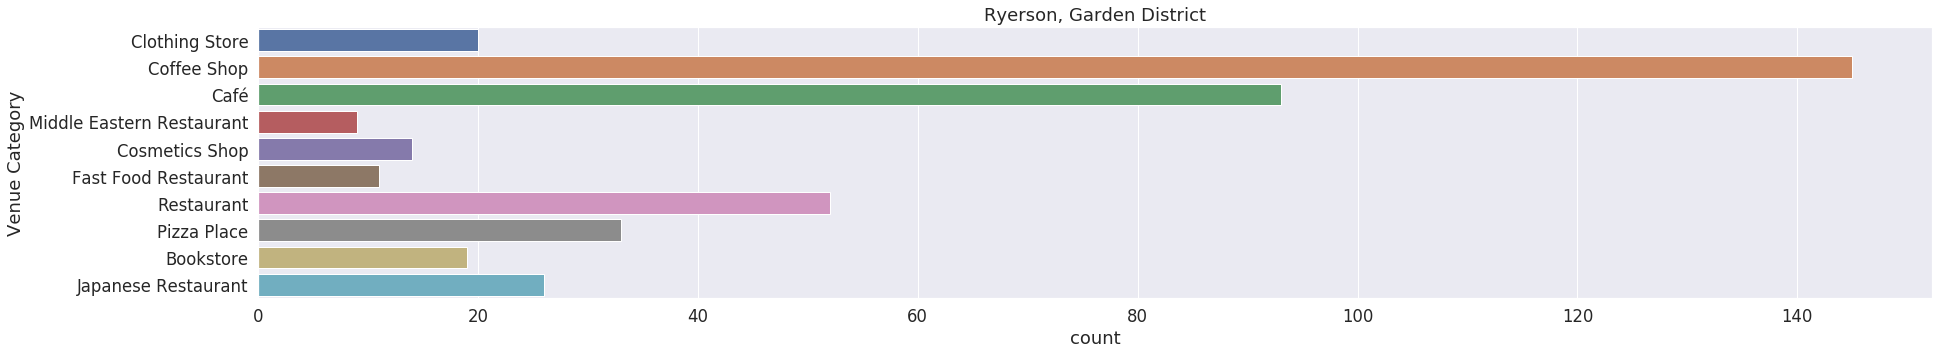

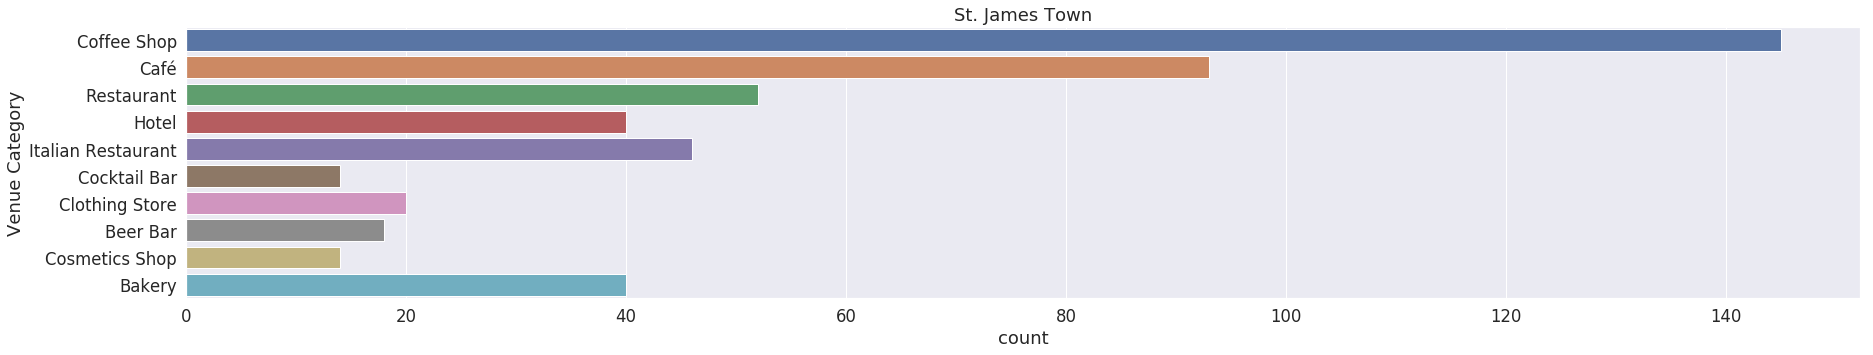

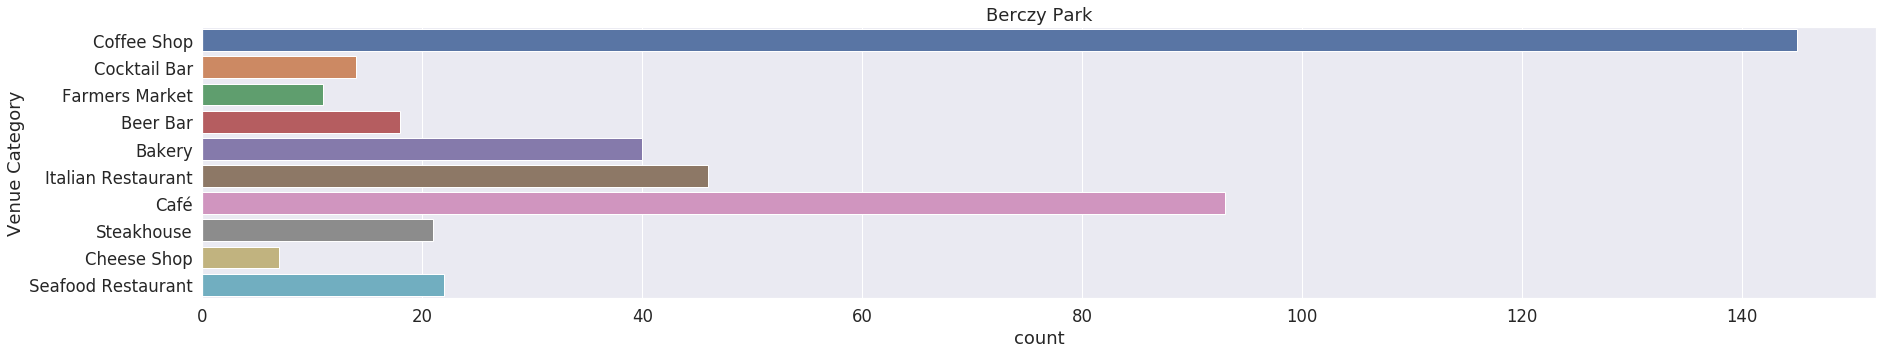

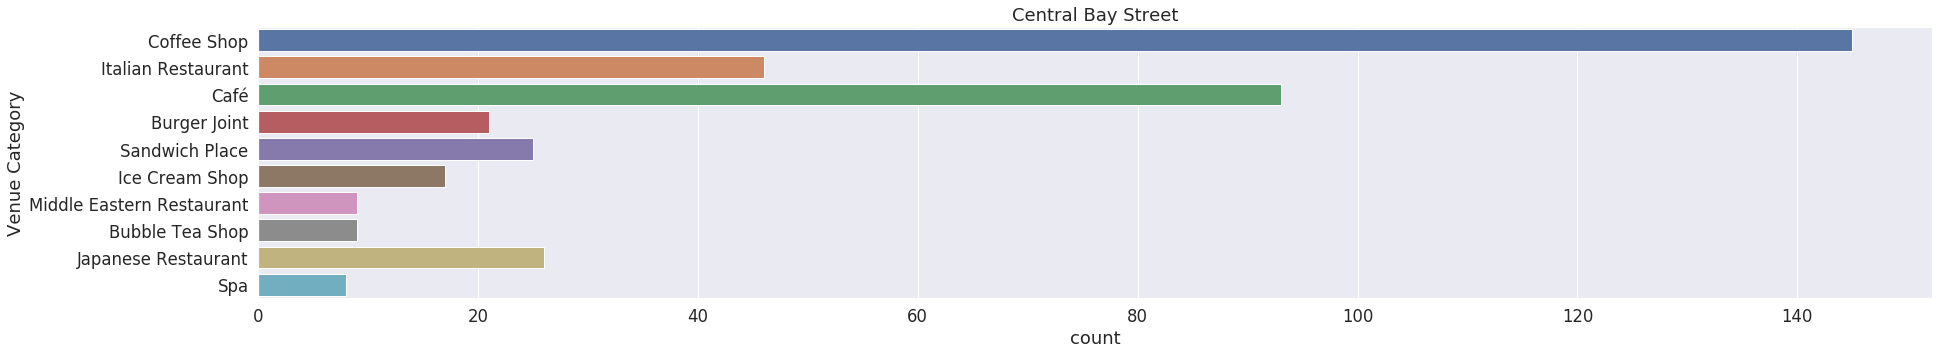

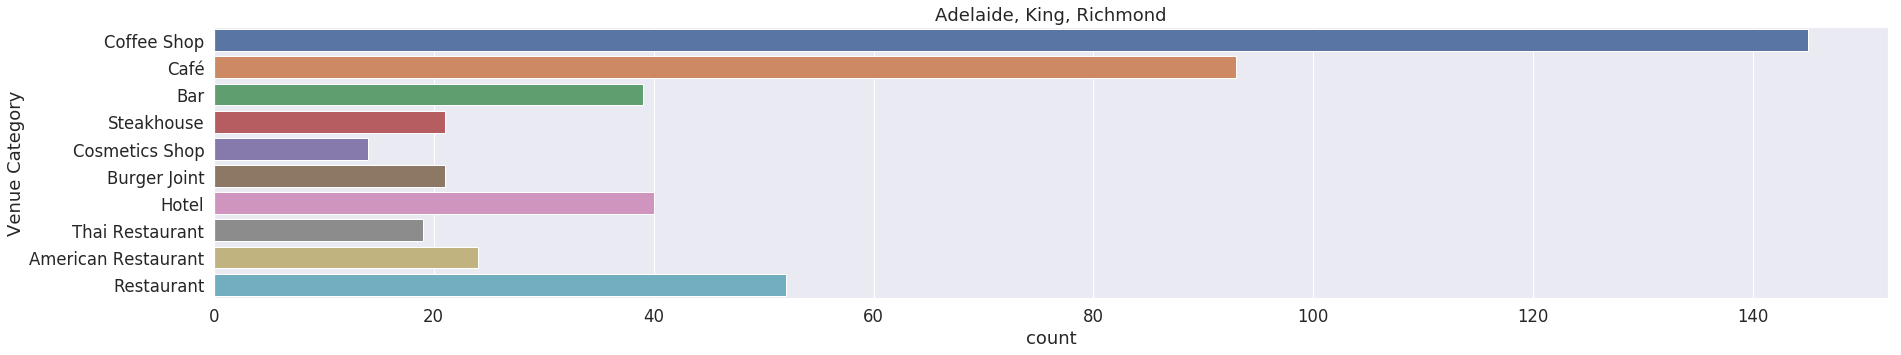

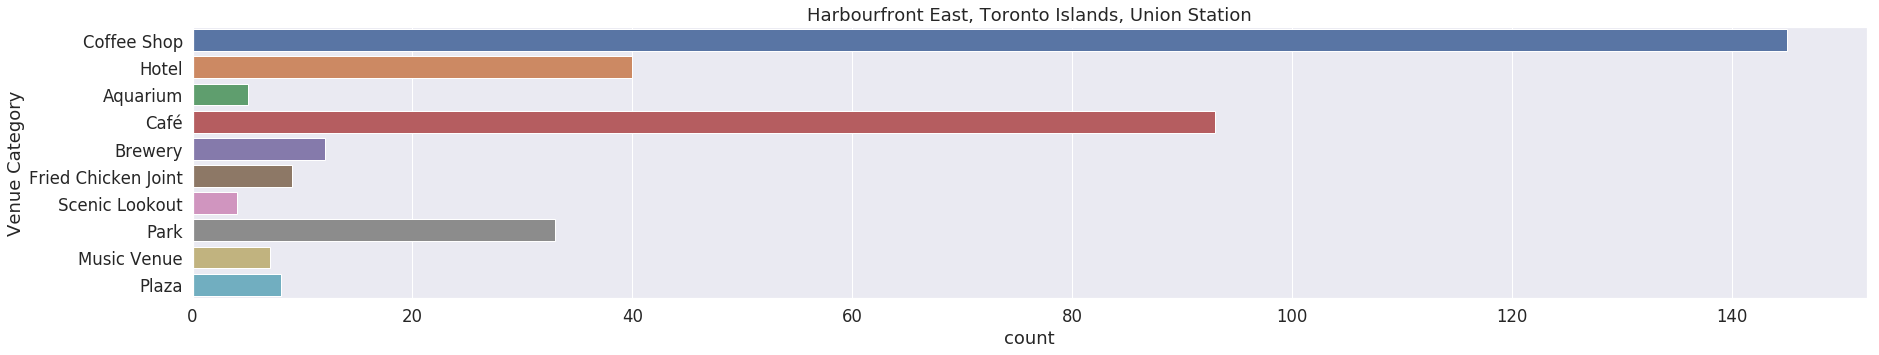

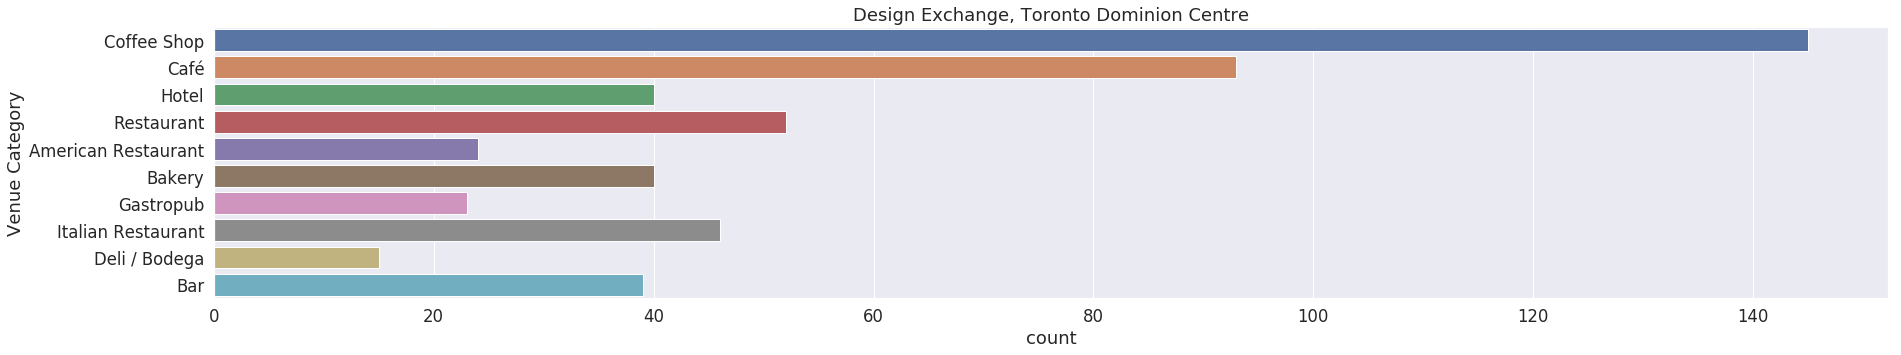

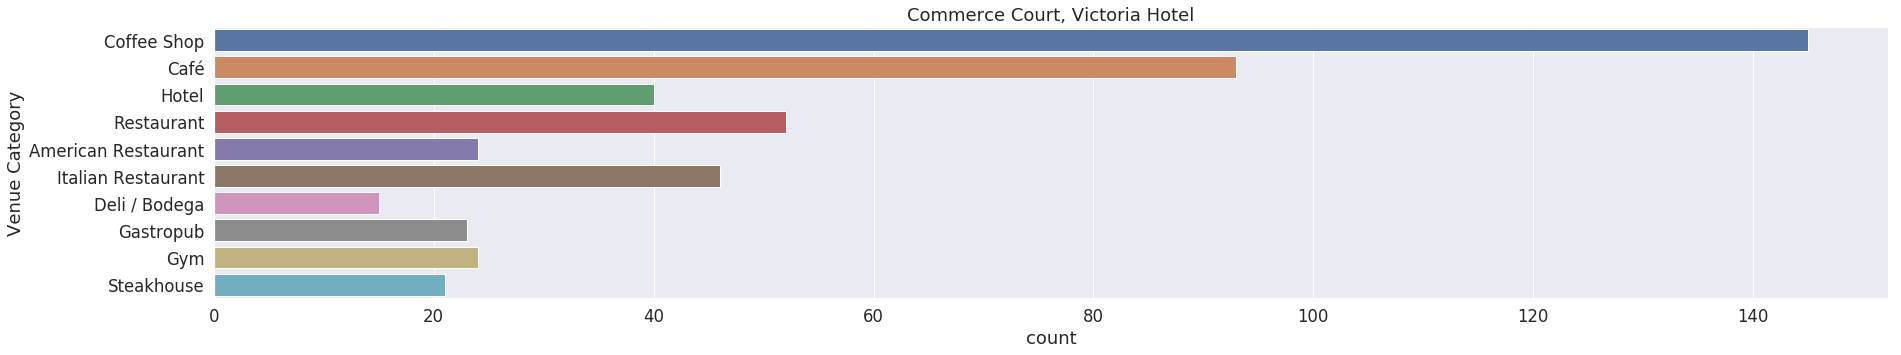

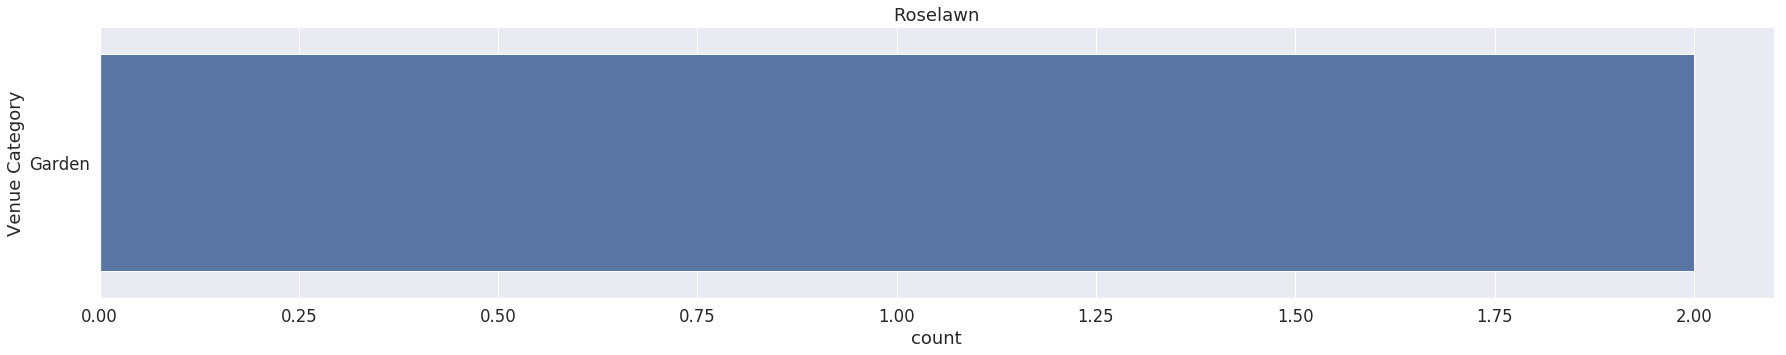

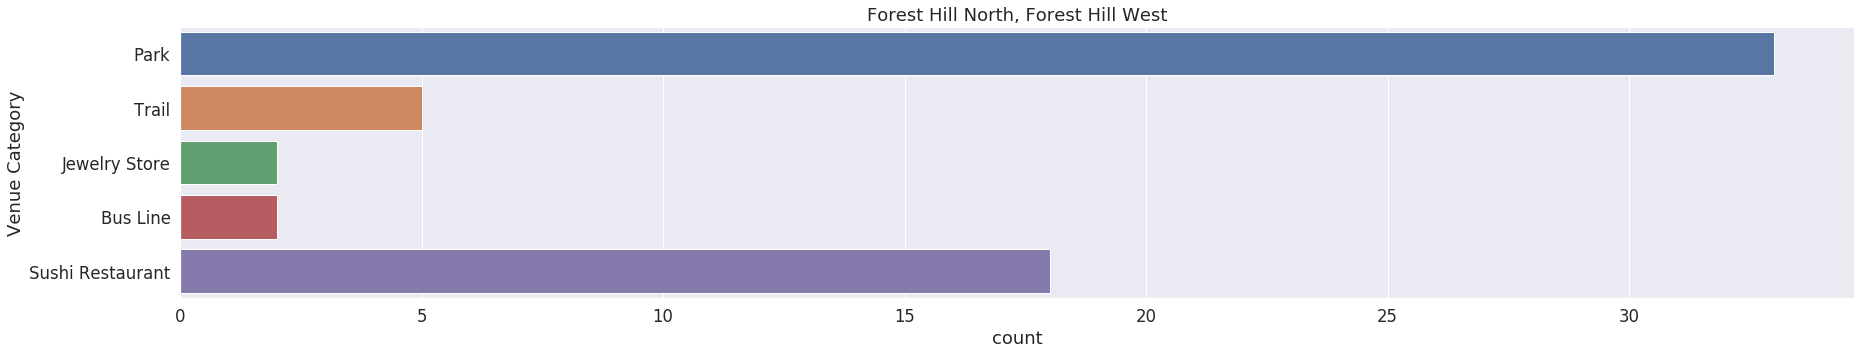

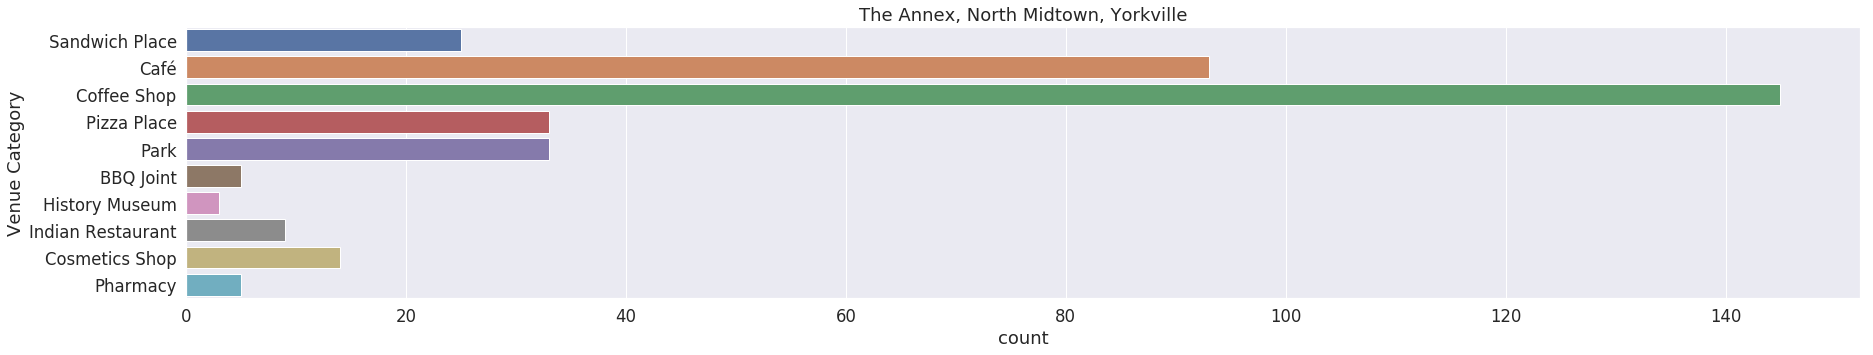

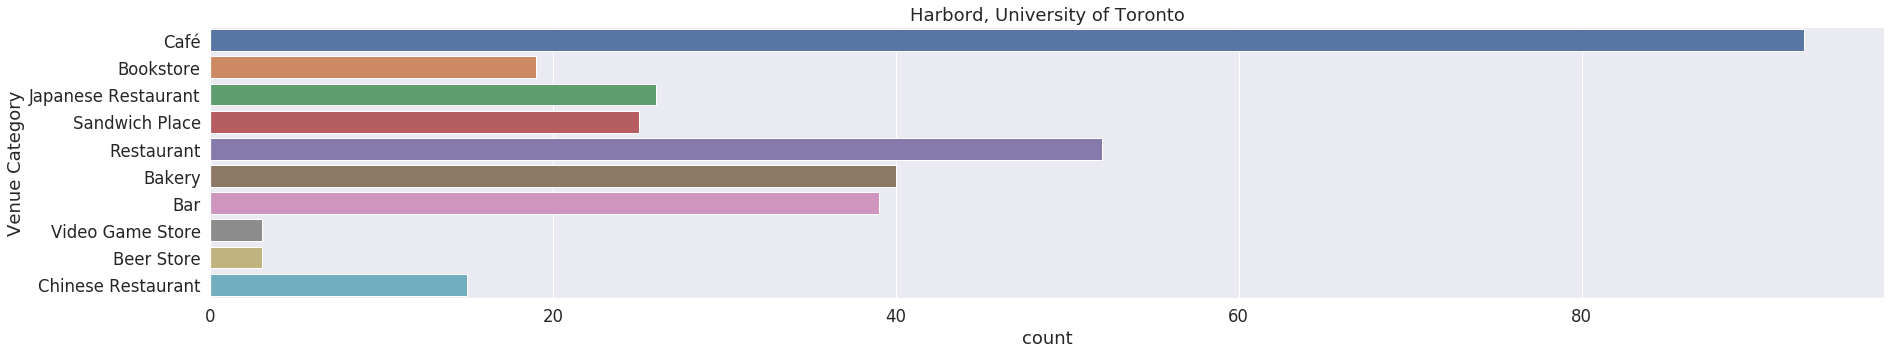

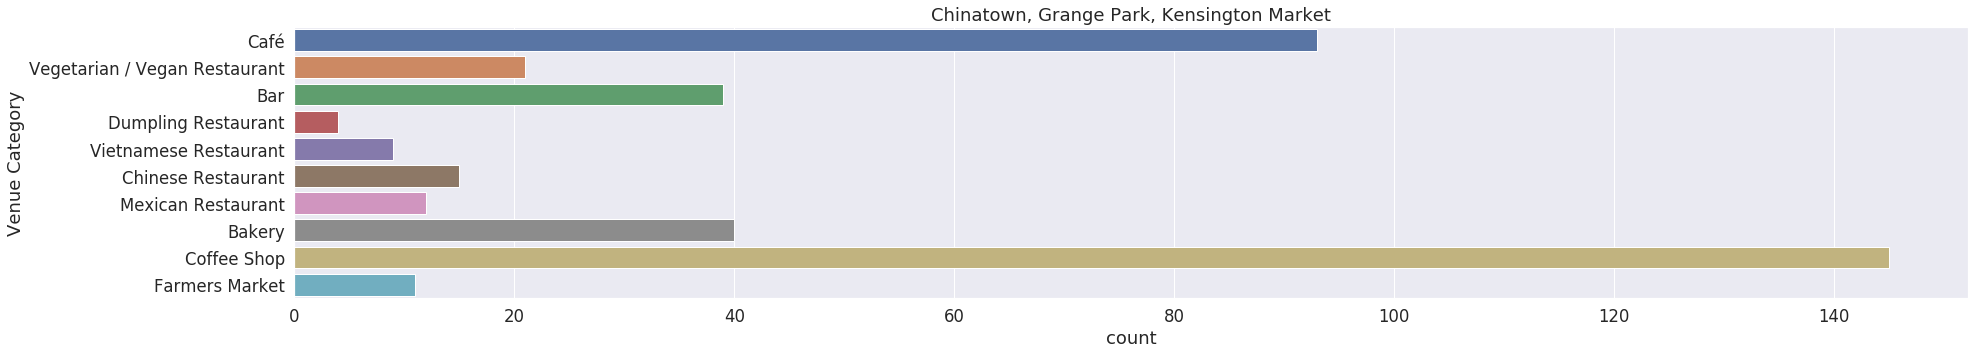

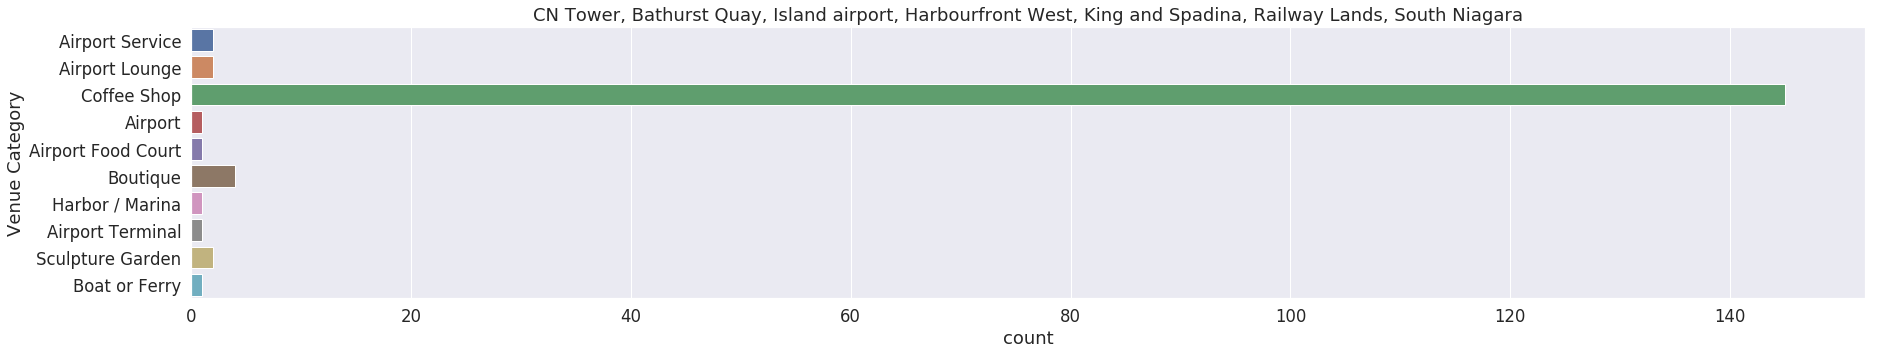

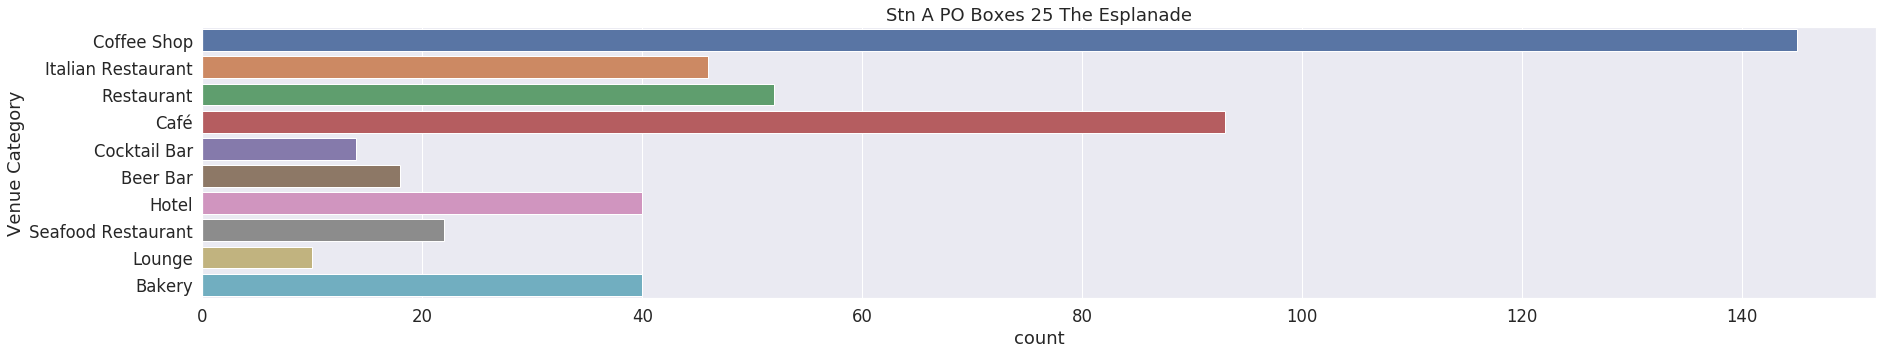

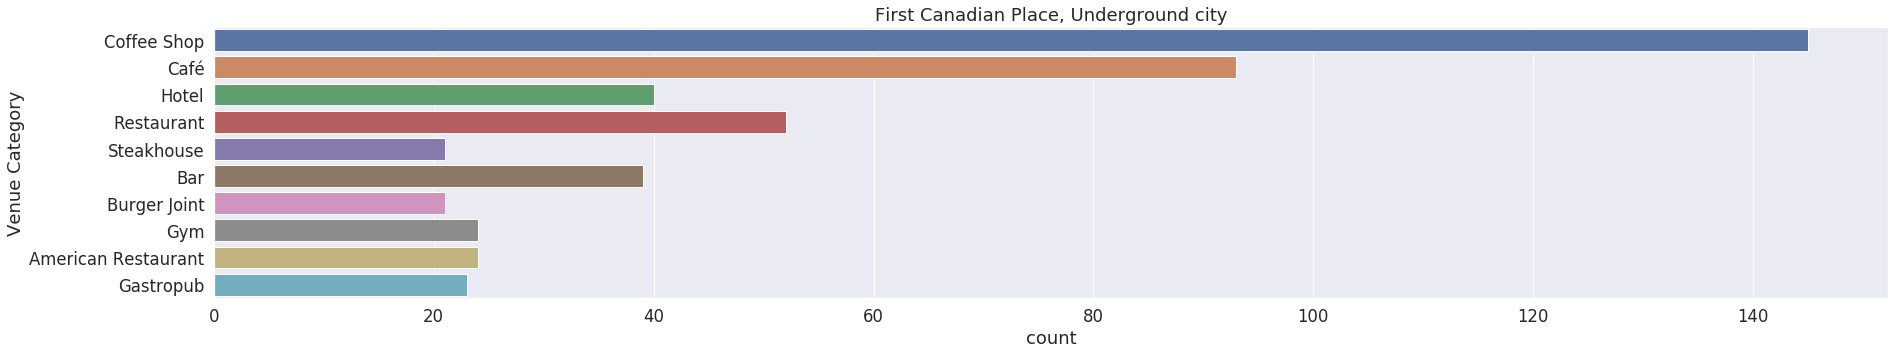

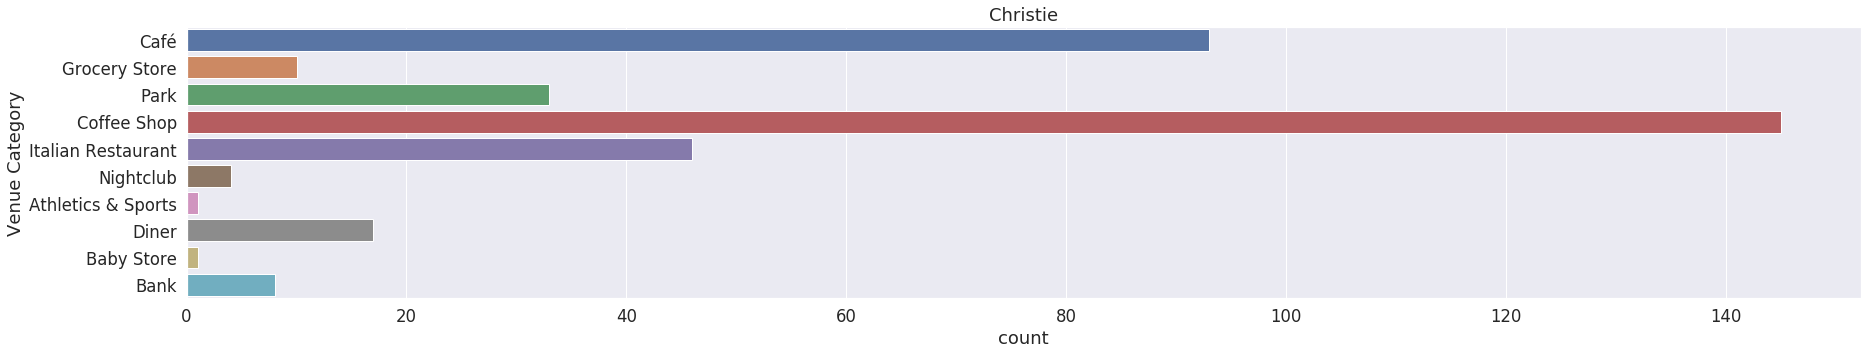

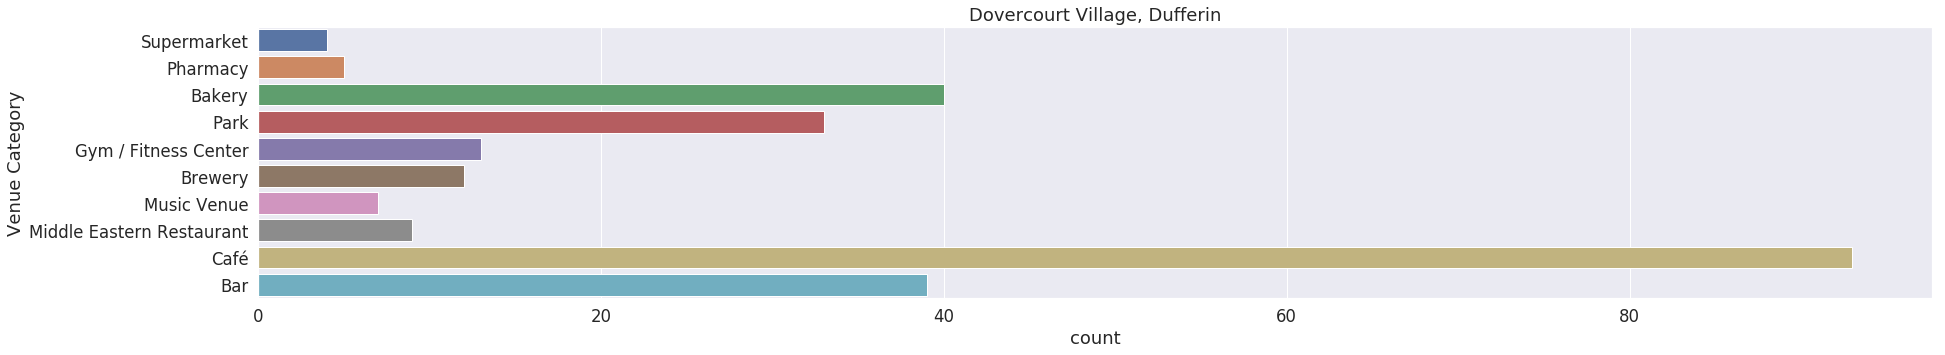

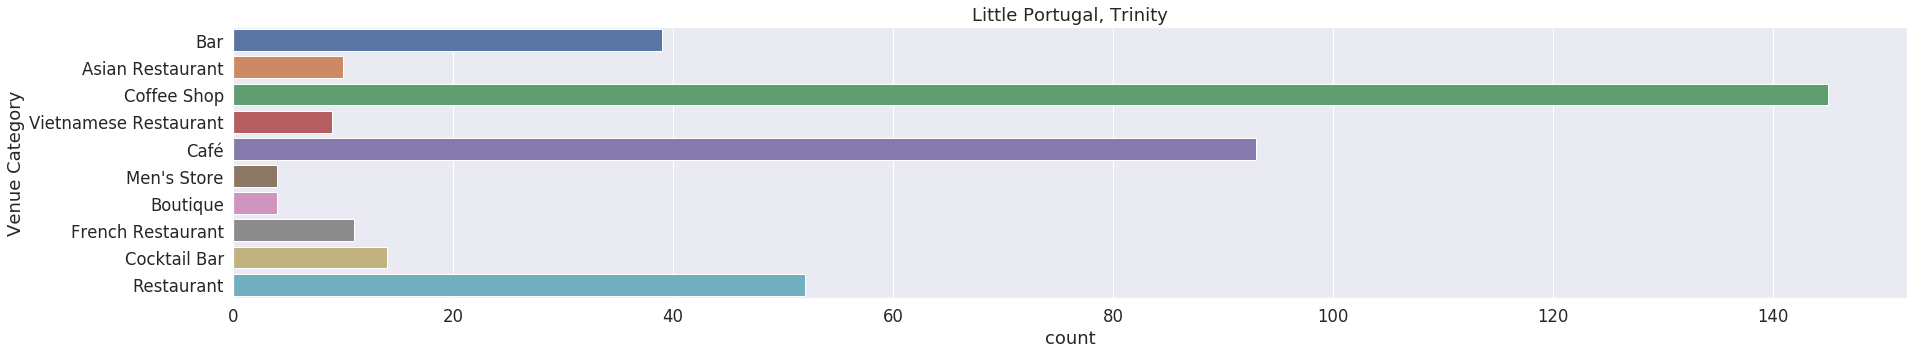

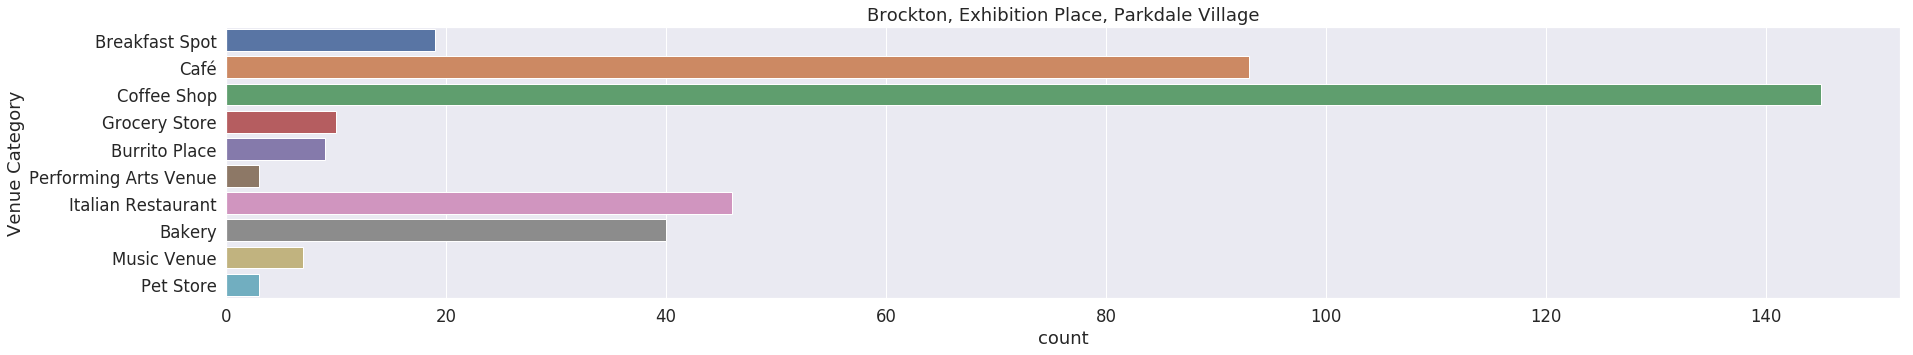

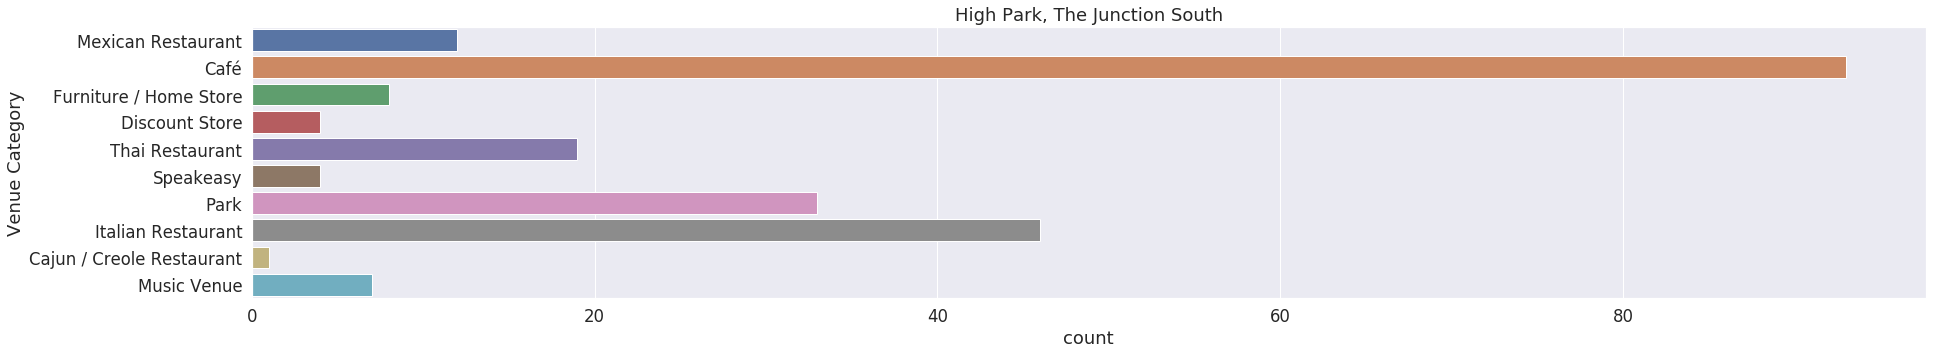

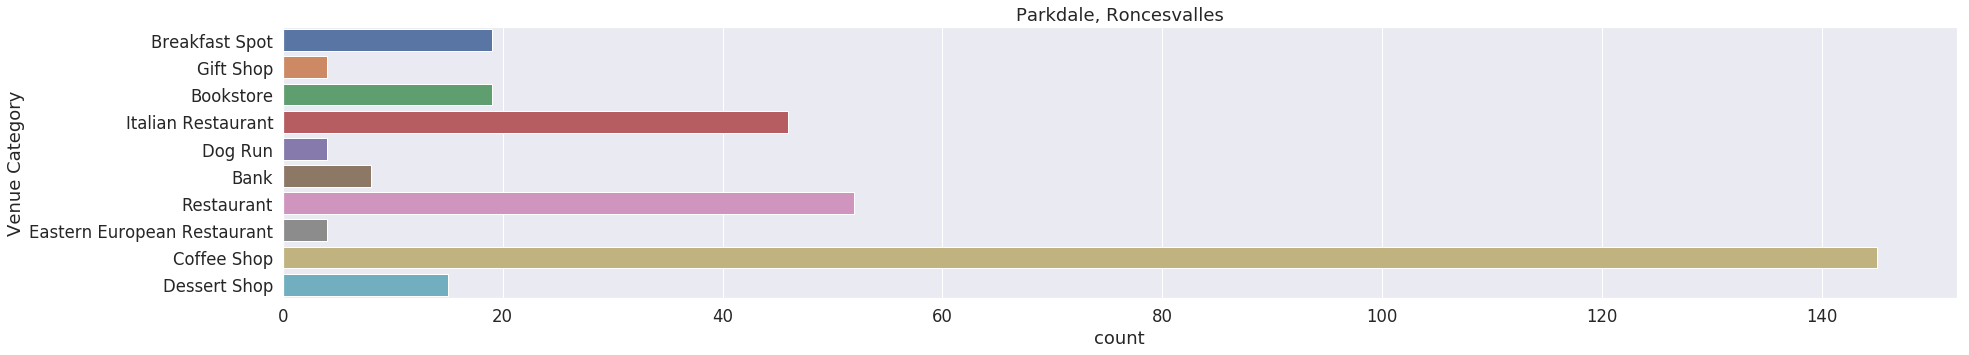

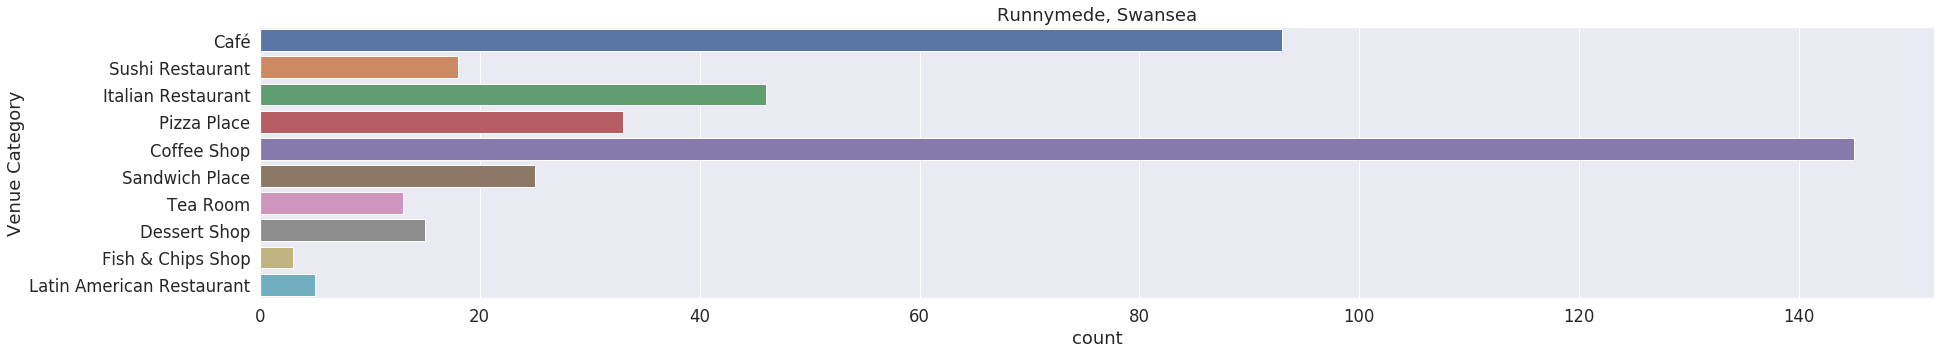

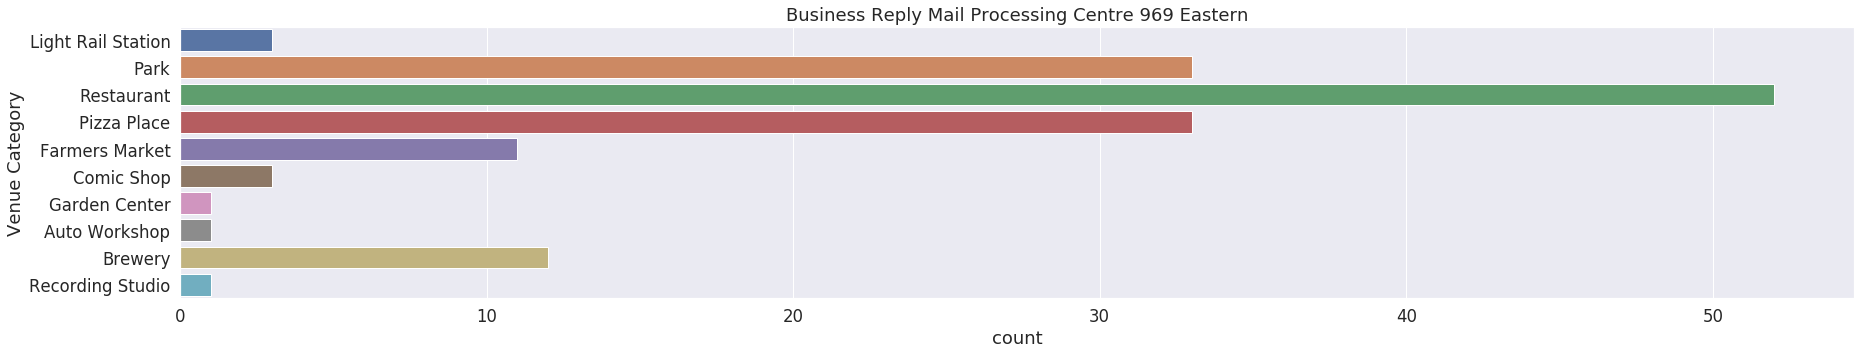

In [192]:
plot_venues(toronto_venues, "Neighborhood")

#### Plotting Venue Category vs Venu Longitude

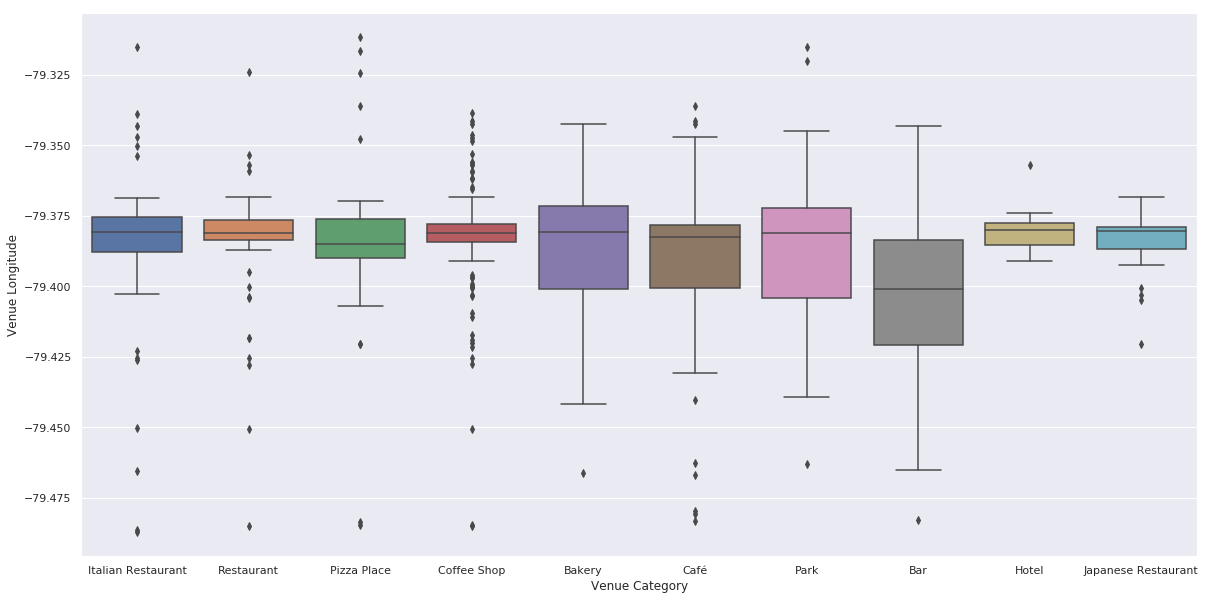

In [69]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1)
indexes = toronto_venues['Venue Category'].value_counts()[:10].index
toronto_venues[toronto_venues['Venue Category'].isin(indexes)]
sns.boxplot(x='Venue Category',y='Venue Longitude',data=toronto_venues[toronto_venues['Venue Category'].isin(indexes)])
plt.savefig('category_longitude.png')

#### Plotting Venue Category vs Venu Latitude

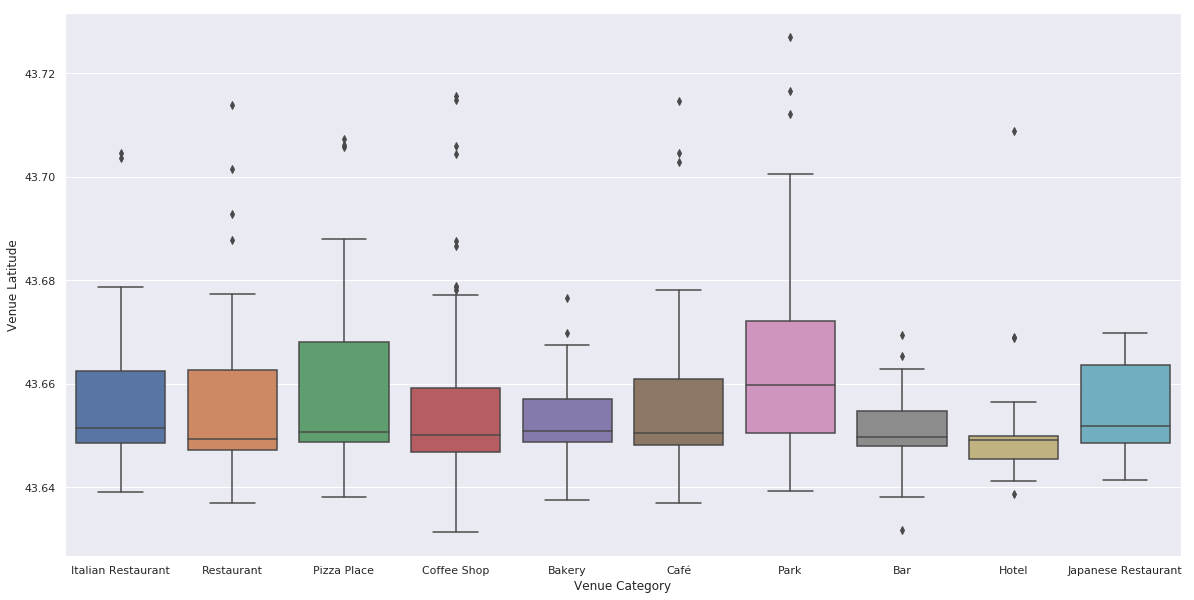

In [174]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1)
indexes = toronto_venues['Venue Category'].value_counts()[:10].index
toronto_venues[toronto_venues['Venue Category'].isin(indexes)]
sns.boxplot(x='Venue Category',y='Venue Latitude',data=toronto_venues[toronto_venues['Venue Category'].isin(indexes)])
plt.savefig("category_latitude.png")

#### Plotting Distribution Venues in Latitude

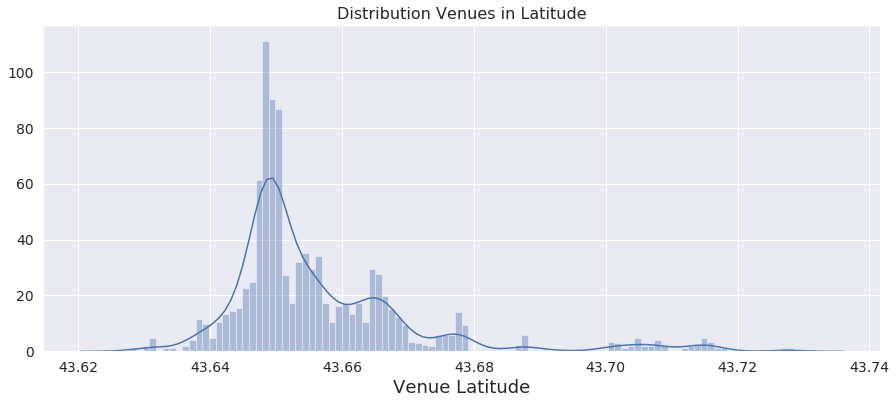

In [193]:
plt.figure(figsize=(15,6))
plt.title('Distribution Venues in Latitude', fontsize=16)
plt.tick_params(labelsize=14)
sns.distplot(toronto_venues['Venue Latitude'], bins=100);

#### Plotting Distribution Venues in Longitude

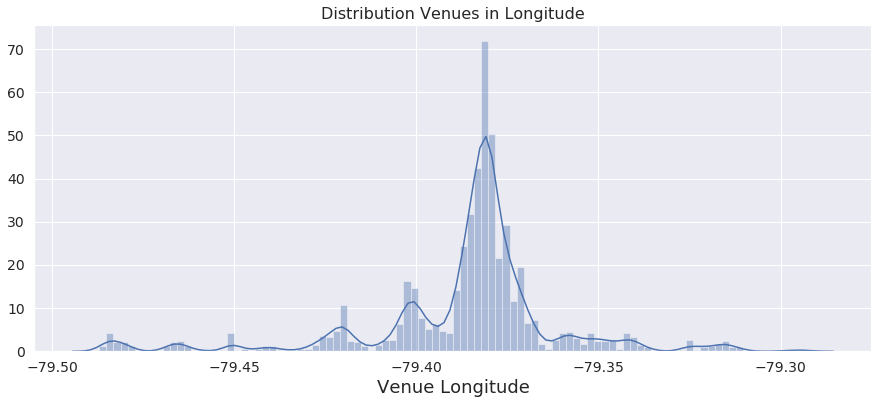

In [194]:
plt.figure(figsize=(15,6))
plt.title('Distribution Venues in Longitude', fontsize=16)
plt.tick_params(labelsize=14)
sns.distplot(toronto_venues['Venue Longitude'], bins=100);

Let's plot on a map the first 10 venues with more presence at Toronto

In [20]:
indexes = toronto_venues['Venue Category'].value_counts()[:10].index
indexes

toronto_top10_venues = toronto_venues[toronto_venues['Venue Category'].isin(indexes)]

colors_array = cm.rainbow(np.linspace(0, 1, len(toronto_top10_venues['Venue Category'].unique())))

In [21]:
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [22]:
categories = toronto_top10_venues['Venue Category'].unique()
color_df = pd.DataFrame(categories)
color_df['color'] = rainbow
color_df.columns = ['Category', 'Color']
color_df.head()

Category    Color
0  Italian Restaurant  #8000ff
1          Restaurant  #4856fb
2         Pizza Place  #10a2f0
3         Coffee Shop  #2adddd
4              Bakery  #62fbc4

In [186]:
toronto_top10_venues['Color'] = toronto_top10_venues['Venue Category'].map(lambda category: color_df[color_df['Category'] == category]['Color'].values[0])
toronto_top10_venues.head()

Neighborhood  Neighborhood Latitude  \
9   The Danforth West, Riverdale              43.679557   
14  The Danforth West, Riverdale              43.679557   
16  The Danforth West, Riverdale              43.679557   
19  The Danforth West, Riverdale              43.679557   
34  The Danforth West, Riverdale              43.679557   

    Neighborhood Longitude              Venue  Venue Latitude  \
9               -79.352188    Cafe Fiorentina       43.677743   
14              -79.352188          7 Numbers       43.677062   
16              -79.352188          Rikkochez       43.677267   
19              -79.352188  Pizzeria Libretto       43.678489   
34              -79.352188  Marvel Coffee Co.       43.678630   

    Venue Longitude      Venue Category    Color  
9        -79.350115  Italian Restaurant  #8000ff  
14       -79.353934  Italian Restaurant  #8000ff  
16       -79.353274          Restaurant  #4856fb  
19       -79.347576         Pizza Place  #10a2f0  
34       -79.347460         Coffee Shop  #2adddd

In [24]:
toronto_top10_venues.shape

(547, 8)

In [25]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [195]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, color, category in zip(toronto_top10_venues['Venue Latitude'], toronto_top10_venues['Venue Longitude'], toronto_top10_venues['Color'], toronto_top10_venues['Venue Category']):
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=category,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
    
legend_html = '<div style="position: fixed;top: 50px; right: 50px; width: auto; border:2px solid grey; z-index:9999; font-size:10px;background-color:#ffffff">'
    
for group in toronto_top10_venues.groupby(['Venue Category', 'Color']).groups.keys():
    legend_html += '&nbsp; ' + group[0] + '&nbsp; <i class="fa fa-map-marker fa-2x" style="color:' + group[1] +  '"></i><br>'

legend_html += '</div>'

map_clusters.get_root().html.add_child(folium.Element(legend_html))

map_clusters

### Density-Based Clustering

In [196]:
df_latlng = toronto_venues[['Venue Latitude', 'Venue Longitude']]
df_latlng.head()

Venue Latitude  Venue Longitude
0       43.676821       -79.293942
1       43.678879       -79.297734
2       43.679181       -79.297215
3       43.680563       -79.292869
4       43.677621       -79.351434

StandardScaler is used to keep relative distances between venues.

In [74]:
latlng = StandardScaler().fit_transform(np.nan_to_num(df_latlng))
latlng[:5]

array([[1.3537186 , 3.45764199],
       [1.49142489, 3.31535502],
       [1.51166107, 3.33481641],
       [1.60411693, 3.49791304],
       [1.40726741, 1.30033056]])

In [75]:
dbscan = DBSCAN(eps=0.2, min_samples=3)
dbscan.fit(latlng)

print('labels:', np.unique(dbscan.labels_))

labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [114]:
toronto_venues['Cluster'] = dbscan.labels_
toronto_venues.head()

Neighborhood  Neighborhood Latitude  \
0                   The Beaches              43.676357   
1                   The Beaches              43.676357   
2                   The Beaches              43.676357   
3                   The Beaches              43.676357   
4  The Danforth West, Riverdale              43.679557   

   Neighborhood Longitude                               Venue  Venue Latitude  \
0              -79.293031                   Glen Manor Ravine       43.676821   
1              -79.293031  The Big Carrot Natural Food Market       43.678879   
2              -79.293031                 Grover Pub and Grub       43.679181   
3              -79.293031                       Upper Beaches       43.680563   
4              -79.352188                            Pantheon       43.677621   

   Venue Longitude     Venue Category  Cluster  
0       -79.293942              Trail        0  
1       -79.297734  Health Food Store        0  
2       -79.297215                Pub        0  
3       -79.292869       Neighborhood        0  
4       -79.351434   Greek Restaurant        1

Next is to create an array of colors to plot each venue on the map based on the cluster this time

In [116]:
colors_array_cluster = cm.rainbow(np.linspace(0, 1, len(toronto_venues['Cluster'].unique())))
rainbow_cluster = [colors.rgb2hex(i) for i in colors_array_cluster]

In [117]:
d = {'Color':rainbow_cluster,'Cluster':list(np.unique(dbscan.labels_))}
df_cluster_color = pd.DataFrame(d)
df_cluster_color.head()

Color  Cluster
0  #8000ff       -1
1  #6826fe        0
2  #504afc        1
3  #386df9        2
4  #208ef4        3

In [131]:
toronto_venues['Cluster Color'] = toronto_venues['Cluster'].map(lambda c: df_cluster_color[df_cluster_color['Cluster'] == c]['Color'].values[0])
toronto_venues.head()

Neighborhood  Neighborhood Latitude  \
0                   The Beaches              43.676357   
1                   The Beaches              43.676357   
2                   The Beaches              43.676357   
3                   The Beaches              43.676357   
4  The Danforth West, Riverdale              43.679557   

   Neighborhood Longitude                               Venue  Venue Latitude  \
0              -79.293031                   Glen Manor Ravine       43.676821   
1              -79.293031  The Big Carrot Natural Food Market       43.678879   
2              -79.293031                 Grover Pub and Grub       43.679181   
3              -79.293031                       Upper Beaches       43.680563   
4              -79.352188                            Pantheon       43.677621   

   Venue Longitude     Venue Category  Cluster Cluster Color  
0       -79.293942              Trail        0       #6826fe  
1       -79.297734  Health Food Store        0       #6826fe  
2       -79.297215                Pub        0       #6826fe  
3       -79.292869       Neighborhood        0       #6826fe  
4       -79.351434   Greek Restaurant        1       #504afc

In [198]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, color, cluster in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Cluster Color'], toronto_venues['Cluster']):
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
    
legend_html = '<div style="position: fixed;top: 50px; right: 50px; width: auto; border:2px solid grey; z-index:9999; font-size:10px;background-color:#ffffff">'
    
for group in toronto_venues.groupby(['Cluster Color', 'Cluster']).groups.keys():
    legend_html += '&nbsp; ' + str(group[1]) + '&nbsp; <i class="fa fa-map-marker fa-2x" style="color:' + str(group[0]) +  '"></i><br>'

legend_html += '</div>'

map_clusters.get_root().html.add_child(folium.Element(legend_html))

map_clusters

#### Cluster Analysis
Let's check which clusters are the most densely populated.

In [149]:
toronto_venues['Cluster'].value_counts()

 9     1228
 16      64
 1       44
 3       38
 5       38
 2       37
 20      35
 12      31
 11      23
 17      22
 18      22
-1       21
 6       20
 14      17
 8       14
 19      14
 15      13
 13      12
 4        6
 10       5
 0        4
 7        3
Name: Cluster, dtype: int64

As we can see in the following list, cluster 9 is overcrowded compared with others. Lets analyze this cluster again with DBSCAN.

In [199]:
toronto_venues_c9 = toronto_venues[toronto_venues['Cluster'] == 9]
toronto_venues_c9.drop(['Cluster', 'Cluster Color'], axis=1, inplace=True) ## Dropping the previous analysis made
toronto_venues_c9.head()

Neighborhood  Neighborhood Latitude  \
199  Cabbagetown, St. James Town              43.667967   
200  Cabbagetown, St. James Town              43.667967   
201  Cabbagetown, St. James Town              43.667967   
202  Cabbagetown, St. James Town              43.667967   
203  Cabbagetown, St. James Town              43.667967   

     Neighborhood Longitude                   Venue  Venue Latitude  \
199              -79.367675             Cranberries       43.667843   
200              -79.367675                F'Amelia       43.667536   
201              -79.367675  Butter Chicken Factory       43.667072   
202              -79.367675          Kingyo Toronto       43.665895   
203              -79.367675              Murgatroid       43.667381   

     Venue Longitude       Venue Category  
199       -79.369407                Diner  
200       -79.368613   Italian Restaurant  
201       -79.369184    Indian Restaurant  
202       -79.368415  Japanese Restaurant  
203       -79.369311           Restaurant

In [200]:
df_latlng = toronto_venues_c9[['Venue Latitude', 'Venue Longitude']]
df_latlng.head()

Venue Latitude  Venue Longitude
199       43.667843       -79.369407
200       43.667536       -79.368613
201       43.667072       -79.369184
202       43.665895       -79.368415
203       43.667381       -79.369311

In [201]:
latlng = StandardScaler().fit_transform(np.nan_to_num(df_latlng))
latlng[:5]

array([[2.38125294, 1.33275947],
       [2.33528933, 1.42433016],
       [2.26587349, 1.35845134],
       [2.08949989, 1.44719023],
       [2.31216006, 1.34378935]])

In [202]:
dbscan = DBSCAN(eps=0.2, min_samples=3)
dbscan.fit(latlng)

print('labels:', np.unique(dbscan.labels_))

labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [203]:
toronto_venues_c9['Cluster'] = dbscan.labels_
toronto_venues_c9.head()

Neighborhood  Neighborhood Latitude  \
199  Cabbagetown, St. James Town              43.667967   
200  Cabbagetown, St. James Town              43.667967   
201  Cabbagetown, St. James Town              43.667967   
202  Cabbagetown, St. James Town              43.667967   
203  Cabbagetown, St. James Town              43.667967   

     Neighborhood Longitude                   Venue  Venue Latitude  \
199              -79.367675             Cranberries       43.667843   
200              -79.367675                F'Amelia       43.667536   
201              -79.367675  Butter Chicken Factory       43.667072   
202              -79.367675          Kingyo Toronto       43.665895   
203              -79.367675              Murgatroid       43.667381   

     Venue Longitude       Venue Category  Cluster  
199       -79.369407                Diner        0  
200       -79.368613   Italian Restaurant        0  
201       -79.369184    Indian Restaurant        0  
202       -79.368415  Japanese Restaurant        0  
203       -79.369311           Restaurant        0

In [204]:
colors_array_cluster = cm.rainbow(np.linspace(0, 1, len(toronto_venues_c9['Cluster'].unique())))
rainbow_cluster = [colors.rgb2hex(i) for i in colors_array_cluster]

d = {'Color':rainbow_cluster,'Cluster':list(np.unique(dbscan.labels_))}
df_cluster_color = pd.DataFrame(d)
df_cluster_color.head()

toronto_venues_c9['Cluster Color'] = toronto_venues_c9['Cluster'].map(lambda c: df_cluster_color[df_cluster_color['Cluster'] == c]['Color'].values[0])
toronto_venues_c9.head()

Neighborhood  Neighborhood Latitude  \
199  Cabbagetown, St. James Town              43.667967   
200  Cabbagetown, St. James Town              43.667967   
201  Cabbagetown, St. James Town              43.667967   
202  Cabbagetown, St. James Town              43.667967   
203  Cabbagetown, St. James Town              43.667967   

     Neighborhood Longitude                   Venue  Venue Latitude  \
199              -79.367675             Cranberries       43.667843   
200              -79.367675                F'Amelia       43.667536   
201              -79.367675  Butter Chicken Factory       43.667072   
202              -79.367675          Kingyo Toronto       43.665895   
203              -79.367675              Murgatroid       43.667381   

     Venue Longitude       Venue Category  Cluster Cluster Color  
199       -79.369407                Diner        0       #622ffe  
200       -79.368613   Italian Restaurant        0       #622ffe  
201       -79.369184    Indian Restaurant        0       #622ffe  
202       -79.368415  Japanese Restaurant        0       #622ffe  
203       -79.369311           Restaurant        0       #622ffe

In [206]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, color, cluster in zip(toronto_venues_c9['Venue Latitude'], toronto_venues_c9['Venue Longitude'], toronto_venues_c9['Cluster Color'], toronto_venues_c9['Cluster']):
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
    
legend_html = '<div style="position: fixed;top: 50px; right: 50px; width: auto; border:2px solid grey; z-index:9999; font-size:10px;background-color:#ffffff">'
    
for group in toronto_venues.groupby(['Cluster Color', 'Cluster']).groups.keys():
    legend_html += '&nbsp; ' + str(group[1]) + '&nbsp; <i class="fa fa-map-marker fa-2x" style="color:' + str(group[0]) +  '"></i><br>'

legend_html += '</div>'

map_clusters.get_root().html.add_child(folium.Element(legend_html))

map_clusters

Now we have the same pattern as before. One cluster (number 2) is overcrowded compared with others.

In [207]:
toronto_venues_c9['Cluster'].value_counts()

 2     964
 15     94
 0      38
 1      36
 9      21
-1      14
 13     12
 16      7
 6       7
 5       6
 4       5
 8       5
 7       4
 11      3
 10      3
 12      3
 3       3
 14      3
Name: Cluster, dtype: int64

In [210]:
toronto_venues_c9['Venue Category'].value_counts().iloc[:20]

Coffee Shop                      119
Café                              64
Hotel                             39
Restaurant                        38
Italian Restaurant                30
Bakery                            30
Japanese Restaurant               23
Bar                               22
Steakhouse                        20
Gastropub                         20
Seafood Restaurant                20
American Restaurant               19
Vegetarian / Vegan Restaurant     18
Burger Joint                      18
Pizza Place                       18
Clothing Store                    17
Beer Bar                          17
Park                              16
Gym                               16
Thai Restaurant                   16
Name: Venue Category, dtype: int64

In [209]:
toronto_venues_c16 = toronto_venues[toronto_venues['Cluster'] == 16]
toronto_venues_c16['Venue Category'].value_counts().iloc[:20]

Bar                                8
Asian Restaurant                   3
Coffee Shop                        3
Vietnamese Restaurant              2
Café                               2
Men's Store                        2
Boutique                           2
French Restaurant                  2
Cocktail Bar                       2
Restaurant                         2
Pizza Place                        2
Yoga Studio                        1
Southern / Soul Food Restaurant    1
Mac & Cheese Joint                 1
Cupcake Shop                       1
Playground                         1
Record Shop                        1
Juice Bar                          1
Art Gallery                        1
Deli / Bodega                      1
Name: Venue Category, dtype: int64

## Results & Discussion

- I analyzed venues from Toronto neighborhoods group by postalcode. One part of it was done on the previous course but I wanted to expand that analysis further. By having venues I could plot the ammount of the them per neighborhood and see what was each one of this composed by.
- A boxplot was used to analyze the top 10 of the most frequent categories for latitude and logitude.
- I plotted distribution of venues bases on their locations. One for latitude and the other for longitude. It seems there is a bigger density between latitudes( 43,64 | 43,66 ) and longitudes (-79,40 |-79,35). It means, most of the venues are here.
- I plotted the top 10 categories on a map confirming the hypotesis of the previous point.
- DBSCAN was used two times, once for the entire dataset and the second one for the most overcrowed cluster. The analysis on these clusters are in the following section.


## Conclusion

We can see that cluster 9 is by far the most crowded cluster calculated with many **Coffe Shops** in it. Most of the **Venue Category** found in this cluster can be grouped as **FOOD** except for the **Hotel**. It makes sense since, for example, travelers want to enjoy the gastronomic options around city and still have a place where to rest nearby. It seems to be a good option for business related with food. As the density increases the cost of terrain does too, so a next step for the analysis might be including terrain cost.

On the other side, the second most crowded cluster is **16** and it has options related with **FOOD** as the previous cluster had, but it has other options related with **shopping** that might be interesting for turists as well.

For investors this analysis can be found very useful to know where to open the next store in the city. It was out of scope the prices of the terrains or the availability of them on the city. This could be the next steps.